# Combining Expert Advice: Comparing Weighted Strategies for Enhanced Portfolio Performance
### Author: Kai Wen Tay

In this notebook, we will be applying various different algorithms that aim to perform nearly as well as the best fixed strategy in hindsight. Instead of rehashing proofs we have already looked at in various settings, we aim to provide a more practical perspective on the problem and see if the theoretical results hold up in practice in a quasi-realistic trading setting.

The algorithms we will be looking at are:
1. **Equal Weights**: This is the strategy that equally weights all the experts.
2. **Greedy Strategy**: This is the strategy selects the expert with the highest previous performance and reduces the weight of the other experts.
3. **Weighted Majority Algorithm**: This strategy creates a portfolio of experts based on their performance and weights them accordingly, iteratively updating the weights based on the performance of the experts.
4. **Randomized Weighted Majority Algorithm**: This strategy is similar to the Weighted Majority Algorithm, but with a randomization factor to prevent the algorithm from getting stuck in a local minimum.

Our dataset will be the top 15 most followed 13F filings from the last 10 years. However, due to 4 of the funds having less than 10 years of data, we will only be using the top 11 most followed 13F filings. Also, we will also only look at the long positions they hold in the tradable/listed US equities market only.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import WMA as wma
import load_wrds
warnings.filterwarnings("ignore")

### Data

In [2]:
# 13f data for the top 15 most followed fund managers
path = '/Users/kaiwentay/Documents/GitHub/Weighted-Majority-Experts/Data/Pulled/mngrdata.parquet'
df = pd.read_parquet(path)
# crsp data for stock price and returns
path2 = '/Users/kaiwentay/Documents/GitHub/Weighted-Majority-Experts/Data/Pulled/crsp_data.parquet'
df2 = pd.read_parquet(path2)

# create combined dataframe
df_grouped = load_wrds.load_combined_grouped(df, df2)

In [3]:
df_grouped

cik  new_fdate  weighted_performance  weighted_risk  risk_reward_ratio
0      0 2013-08-15              0.105717       0.225075           0.469697
1      0 2013-11-15              0.120796       0.230282           0.524559
2      0 2014-02-15              0.042141       0.203660           0.206916
3      0 2014-05-16              0.085802       0.176434           0.486312
4      0 2014-08-15             -0.066703       0.218603          -0.305131
..   ...        ...                   ...            ...                ...
446   10 2022-08-15              0.026824       0.131701           0.203671
447   10 2022-11-15              0.109212       0.243857           0.447854
448   10 2023-02-15             -0.101570       0.142149          -0.714535
449   10 2023-05-16              0.216093       0.137500           1.571589
450   10 2023-08-15              0.024476       0.153369           0.159587

[451 rows x 5 columns]

## Individual Performances
Here is a quick look at the individual performances of the top 11 most followed 13F filings.

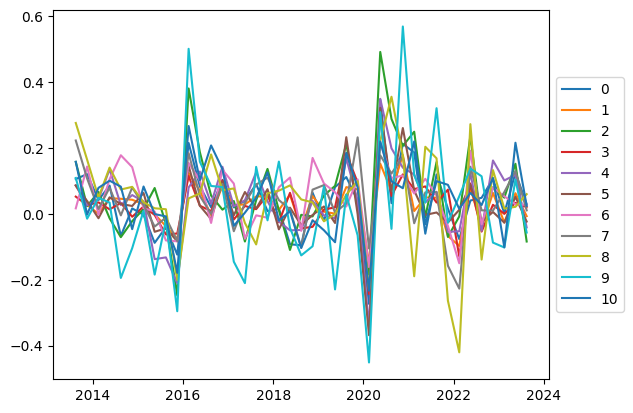

In [4]:
# plot performance of each cik over time
for cik in df_grouped['cik'].unique():
    df_temp = df_grouped[df_grouped['cik'] == cik]
    plt.plot(df_temp['new_fdate'], df_temp['weighted_performance'], label=cik)
# legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

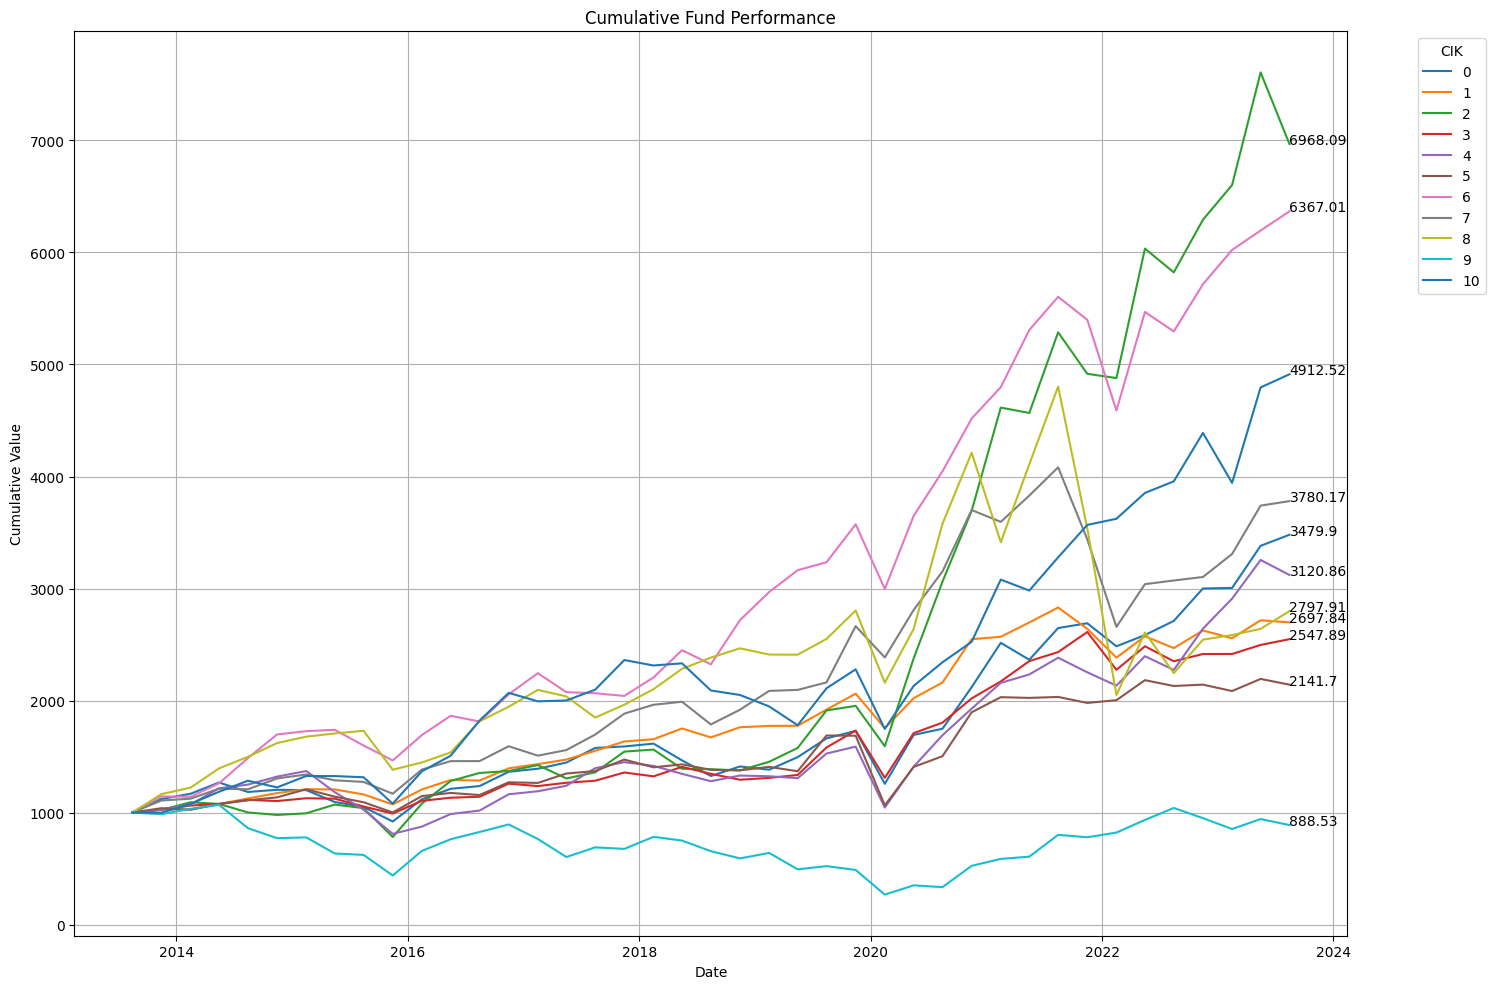

In [5]:
def plot_individual_cumulative_performance(df_grouped, initial_value=1000):
    # Pivot the DataFrame to have new_fdate as index and cik as columns
    performance_pivot = df_grouped.pivot(index='new_fdate', columns='cik', values='weighted_performance')
    
    # Initialize a DataFrame to store cumulative performance
    cumulative_performance = pd.DataFrame(index=performance_pivot.index, columns=performance_pivot.columns)
    
    # Set initial value for each fund
    cumulative_performance.iloc[0] = initial_value
    
    # Calculate cumulative performance
    for cik in performance_pivot.columns:
        for i in range(1, len(performance_pivot)):
            cumulative_performance.iloc[i][cik] = cumulative_performance.iloc[i-1][cik] * (1 + performance_pivot.iloc[i][cik])
    
    # Plot cumulative performance for each fund
    plt.figure(figsize=(15, 10))
    for cik in cumulative_performance.columns:
        plt.plot(cumulative_performance.index, cumulative_performance[cik], label=str(cik))
    
    plt.title('Cumulative Fund Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Value')
    plt.legend(title='CIK', bbox_to_anchor=(1.05, 1), loc='upper left')

    # label the final value of each fund at the end of the final date
    for cik in cumulative_performance.columns:
        plt.text(cumulative_performance.index[-1], cumulative_performance[cik].iloc[-1], str(round(cumulative_performance[cik].iloc[-1], 2)))
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_individual_cumulative_performance(df_grouped, initial_value=1000)

## Equal Weight
- We can also choose to invest equally in all the fund managers. This is a simple strategy that is easy to implement and does not require any optimization.

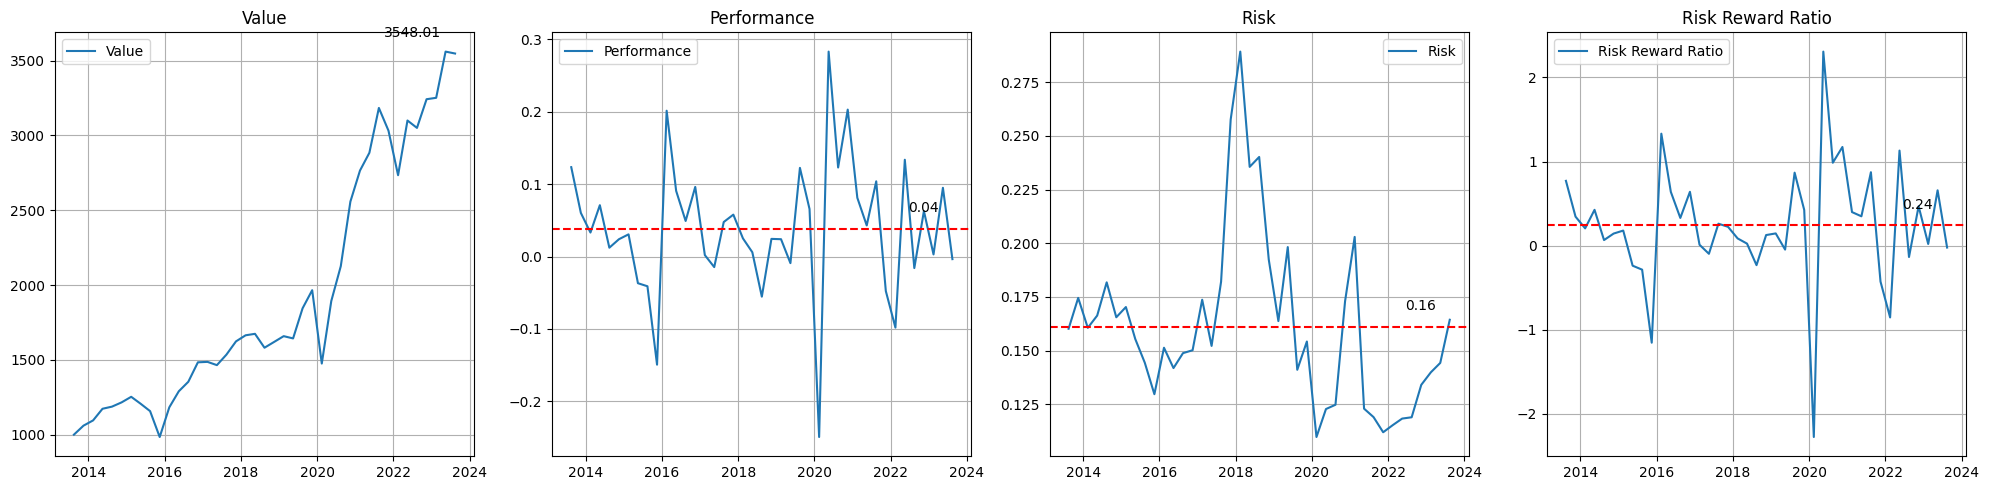

In [31]:
initial_value = 1000
equal_weighted = wma.equal_weighted_strategy(df_grouped, initial_value=1000, plot=False)
#rename equal_weighted columns
equal_weighted = equal_weighted.rename(columns={'Weighted Performance': 'Performance',
                                                'Weighted Risk': 'Risk'})
wma.plot_performance_metrics(equal_weighted)

In [33]:
# print final value, mean performance, risk and risk-reward for equal weighted strategy
final_value = equal_weighted['Value'].iloc[-1]
mean_performance = equal_weighted['Performance'].mean()
risk = equal_weighted['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 3548.0090396772534
Mean Performance: 0.03847681088262697
Risk: 0.16102772225646197
Risk-Reward: 0.23894525950846277


## Best Expert Strategy
- We can also choose to invest in the best fund manager.
- This is a simple strategy that can be used as a benchmark.

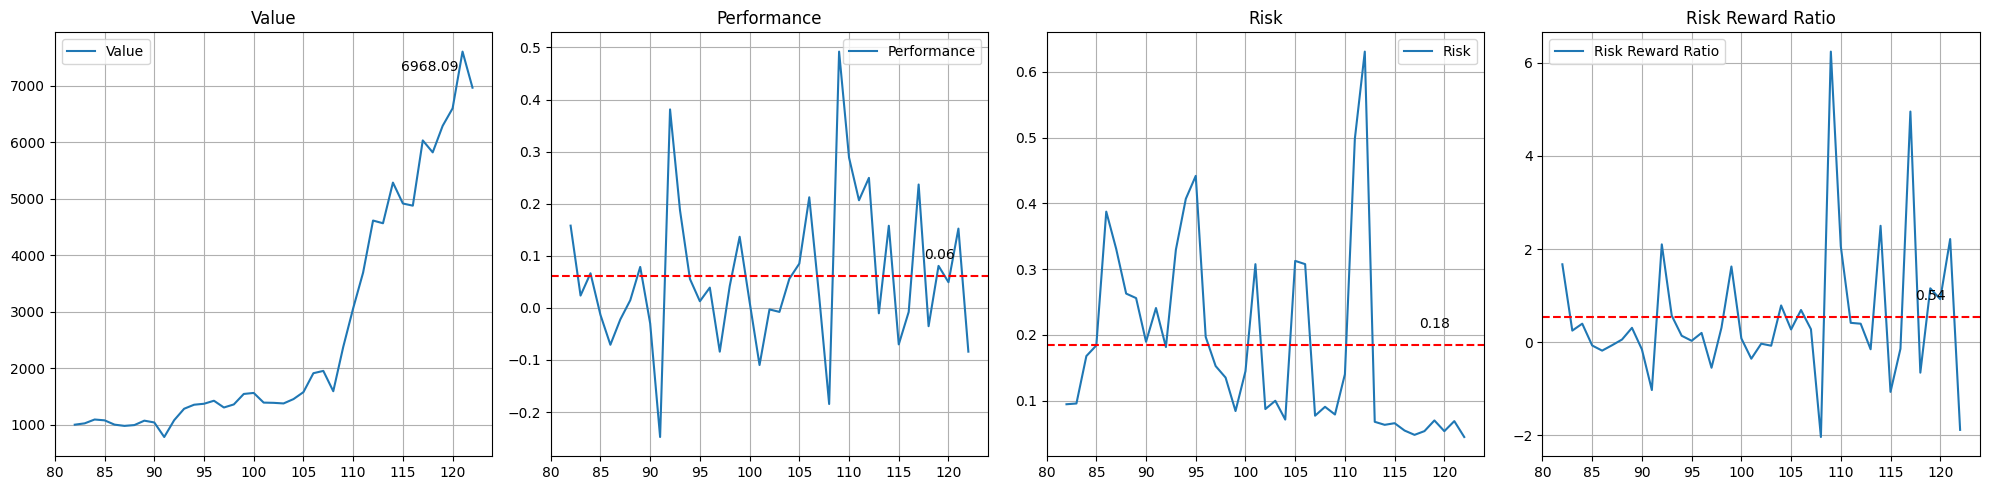

Fund No. with best performance:  [2]


In [6]:
initial_value = 1000
best_expert_performance = wma.best_expert_strategy(df_grouped, initial_value=1000, criterion='performance')
print('Fund No. with best performance: ', best_expert_performance['cik'].unique())

In [34]:
# print final value, mean performance, risk and risk-reward for best expert strategy
final_value = best_expert_performance['Value'].iloc[-1]
mean_performance = best_expert_performance['Performance'].mean()
risk = best_expert_performance['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 6968.090726417322
Mean Performance: 0.06134610311028156
Risk: 0.1846607618267548
Risk-Reward: 0.33220973694365724


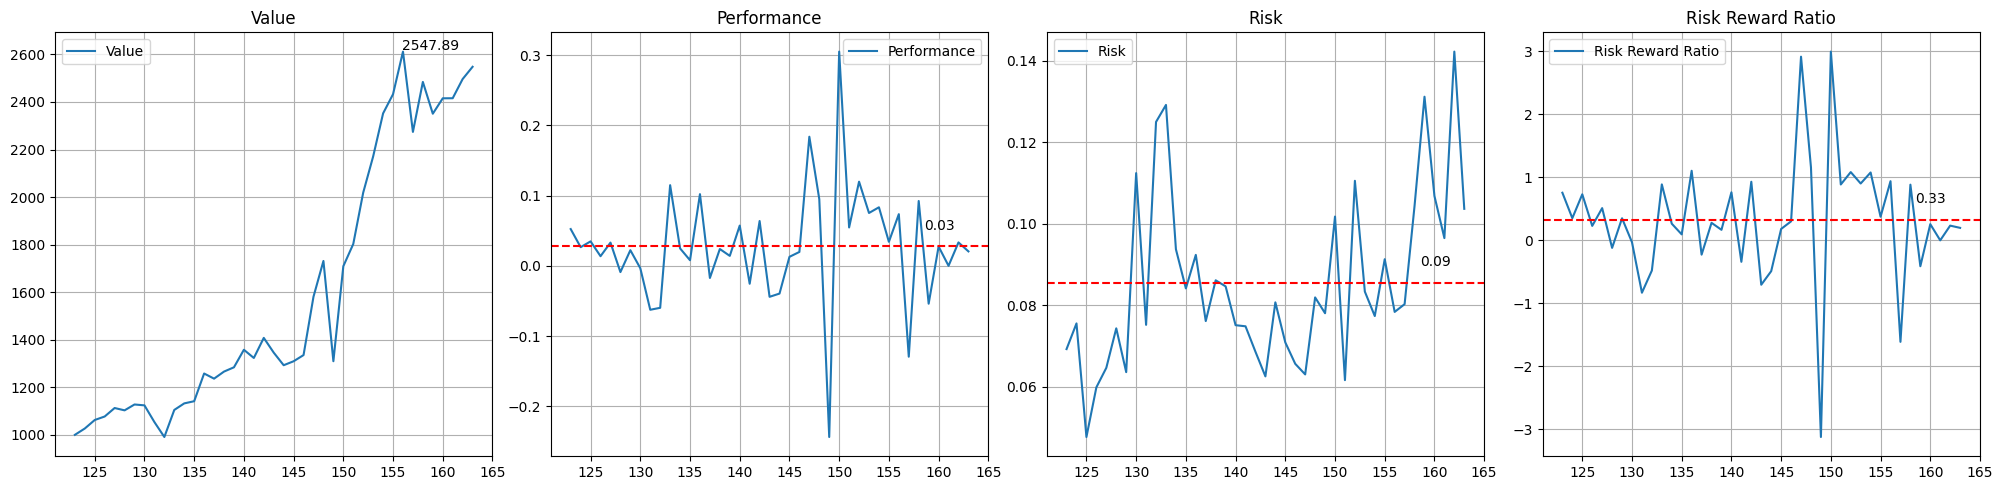

Fund No. with best risk:  [3]


In [7]:
best_expert_risk = wma.best_expert_strategy(df_grouped, initial_value=1000, criterion='risk')
print('Fund No. with best risk: ', best_expert_risk['cik'].unique())

In [37]:
# print final value, mean performance, risk and risk-reward for best expert strategy
final_value = best_expert_risk['Value'].iloc[-1]
mean_performance = best_expert_risk['Performance'].mean()
risk = best_expert_risk['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 2547.8914686488442
Mean Performance: 0.027757770810376323
Risk: 0.08549179388189082
Risk-Reward: 0.32468345264487514


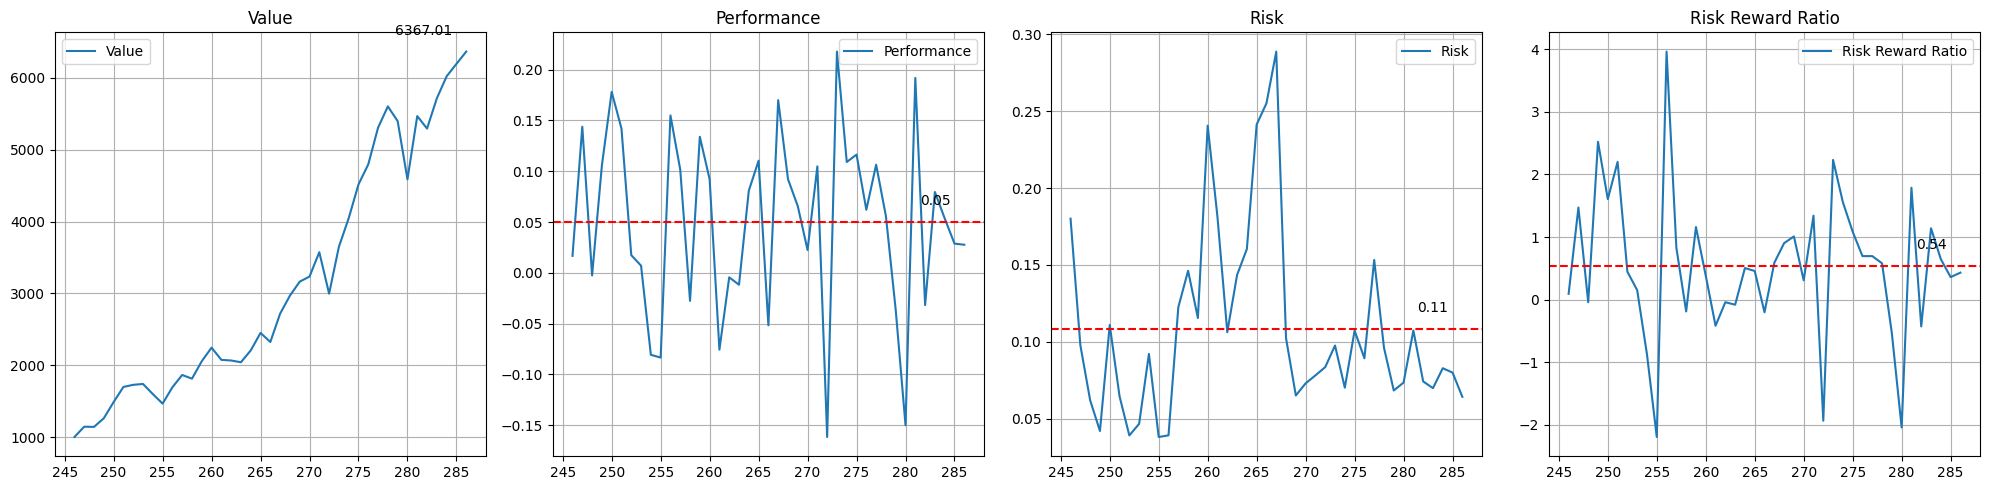

Fund No. with best risk-reward:  [6]


In [8]:
best_expert_risk_reward = wma.best_expert_strategy(df_grouped, initial_value=1000, criterion='risk_reward')
print('Fund No. with best risk-reward: ', best_expert_risk_reward['cik'].unique())

In [36]:
# print final value, mean performance, risk and risk-reward for best expert strategy
final_value = best_expert_risk_reward['Value'].iloc[-1]
mean_performance = best_expert_risk_reward['Performance'].mean()
risk = best_expert_risk_reward['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 6367.009768922969
Mean Performance: 0.050497679071975096
Risk: 0.10849234865254061
Risk-Reward: 0.46544922014454493


## Modified Greedy Algorithm
- We can also use a greedy algorithm to choose the best fund manager every quarter.
- We will choose the fund manager that has the highest return in the previous quarter and reduce all the other fund managers' weights by a certain beta

Optimal beta: 0.16
Final value with optimal beta: 3267.444200097097


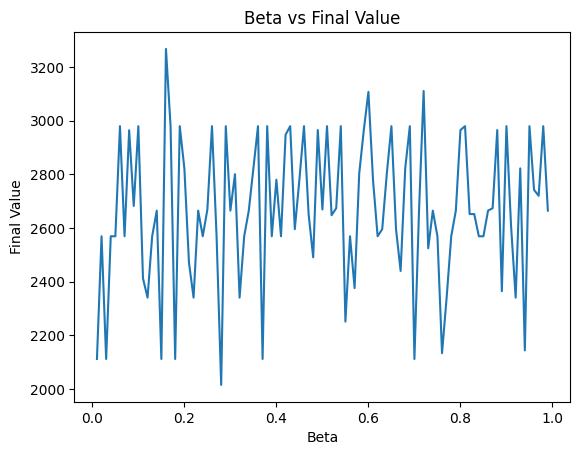

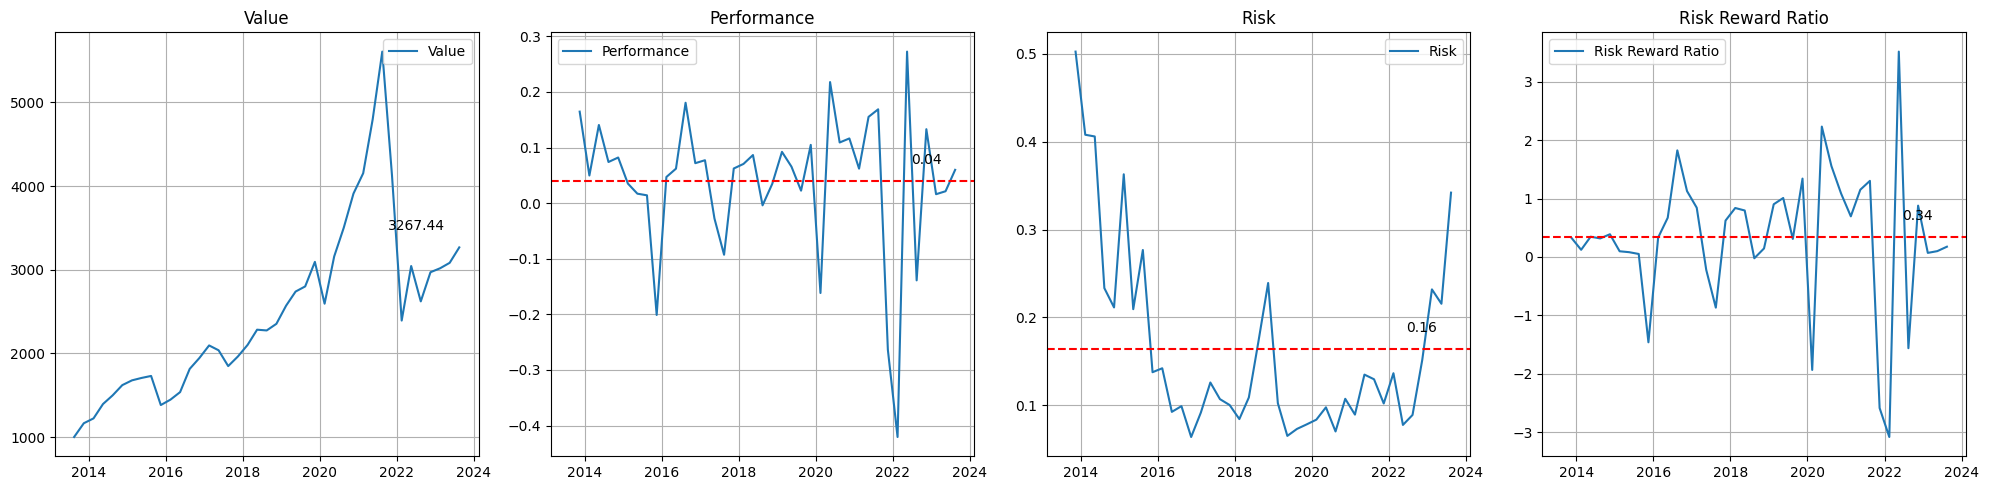

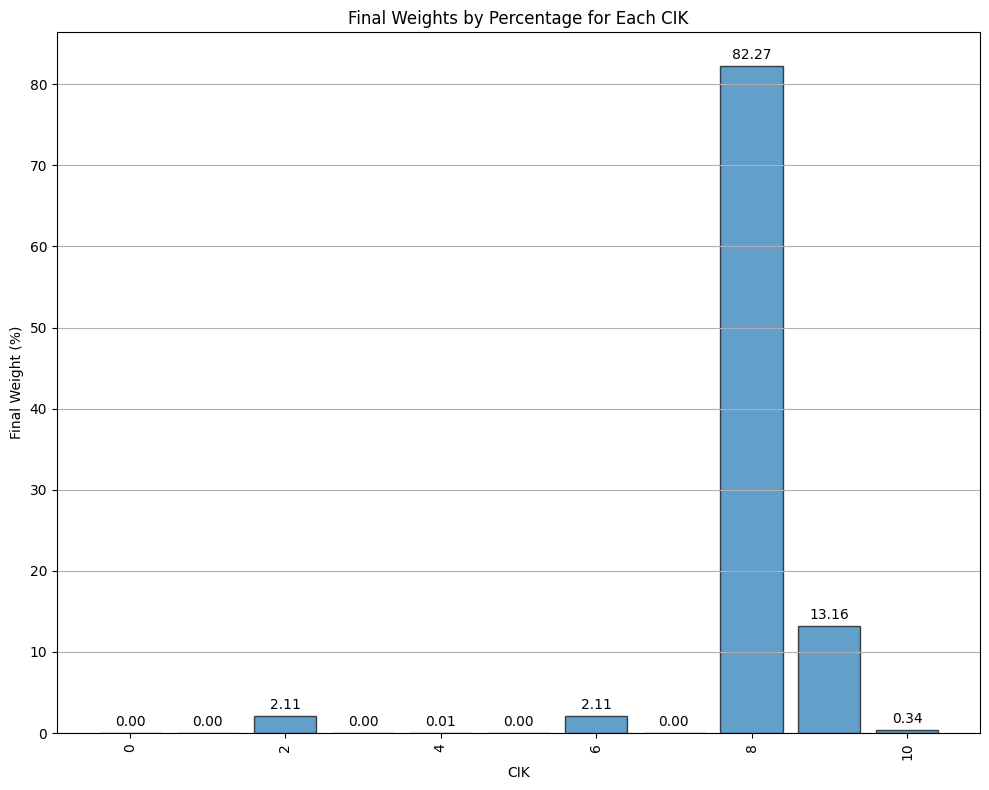

In [9]:
beta_values = np.linspace(0.01, 0.99, 99)
best_performance, best_weights_performance, beta_values, final_values = wma.greedy_strategy(df_grouped, beta_values, criterion='performance')
wma.plot_performance_metrics(best_performance)
wma.plot_final_weights(best_weights_performance)

Optimal beta: 0.09
Final value with optimal beta: -0.09050585515133815


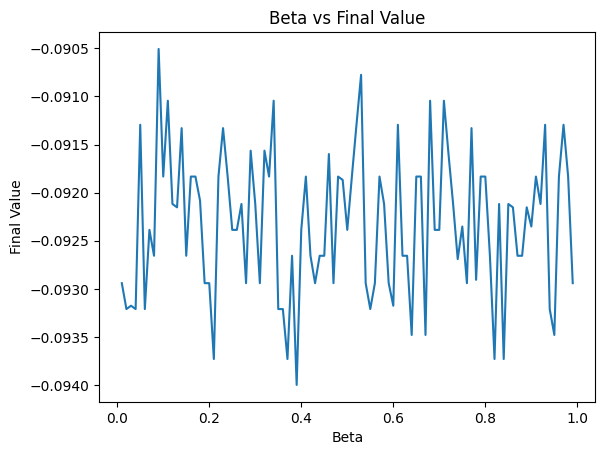

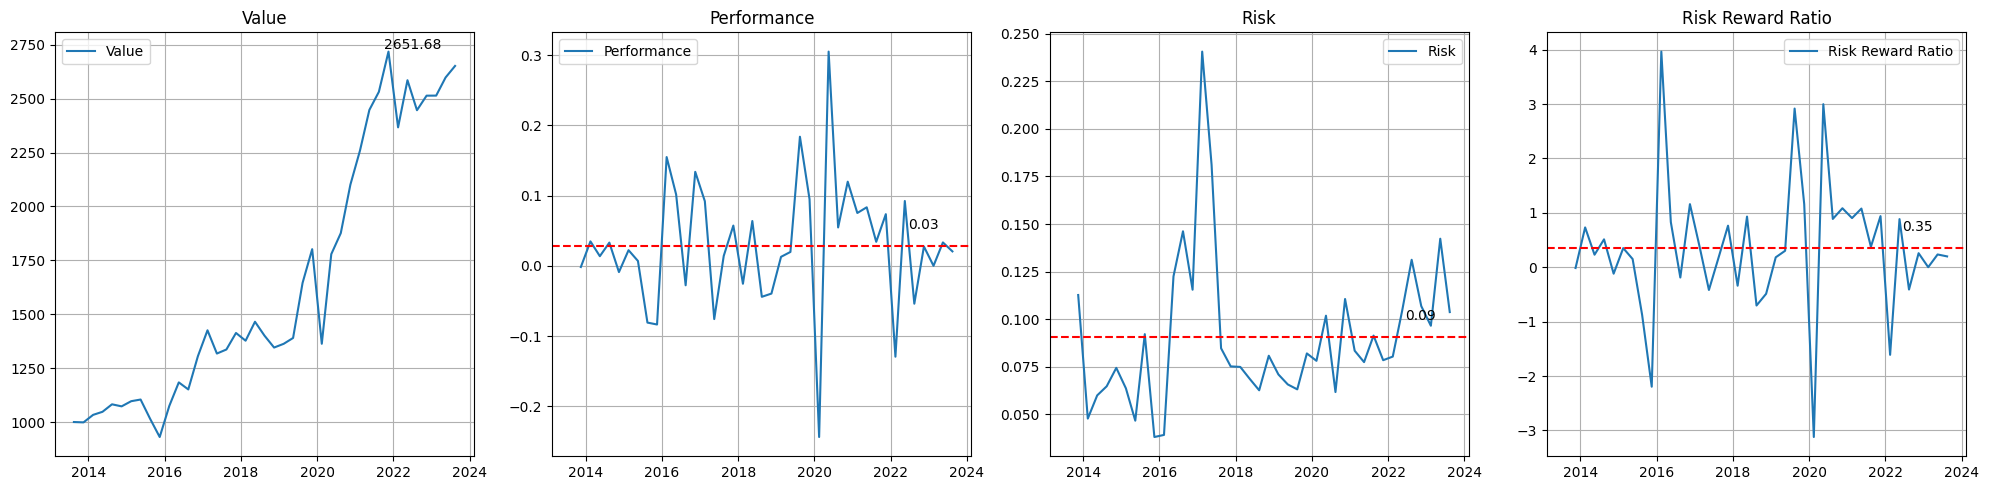

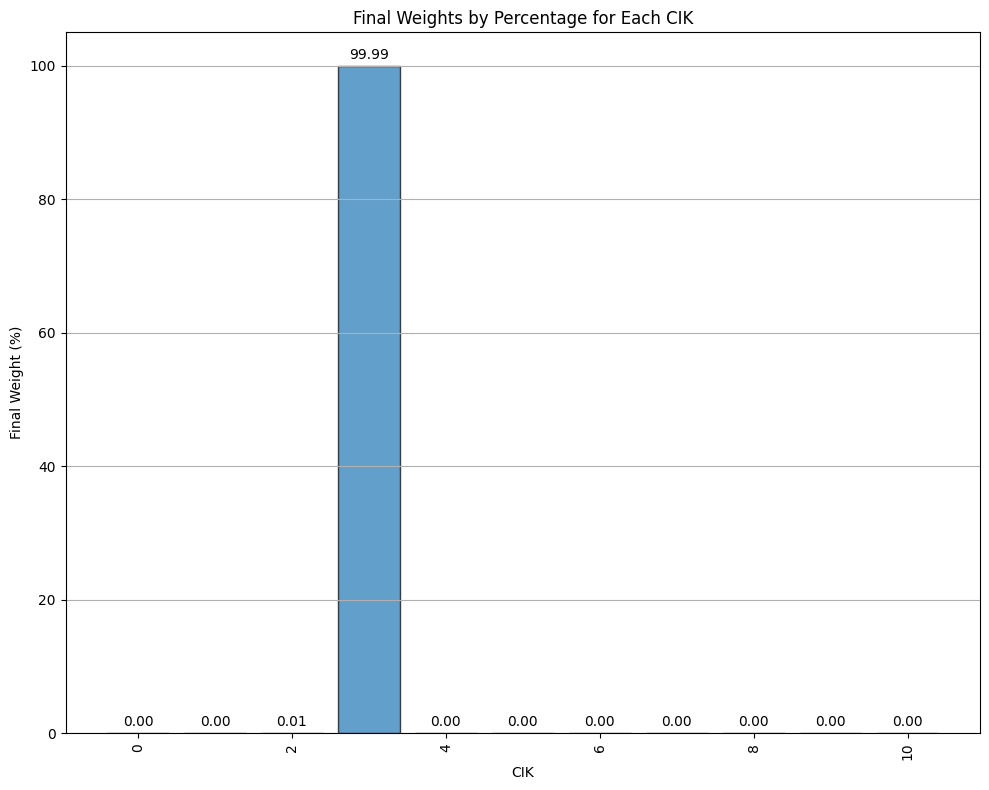

In [10]:
beta_values = np.linspace(0.01, 0.99, 99)
best_risk, best_weights_risk, beta_values_1, final_values_1 = wma.greedy_strategy(df_grouped, beta_values, criterion='risk')
wma.plot_performance_metrics(best_risk)
wma.plot_final_weights(best_weights_risk)

Optimal beta: 0.13
Final value with optimal beta: 0.5144228287002867


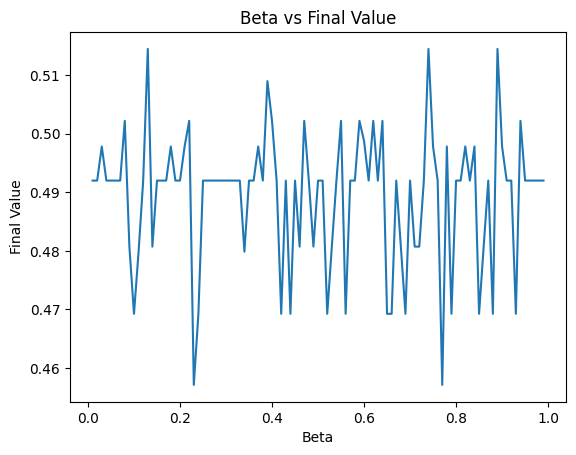

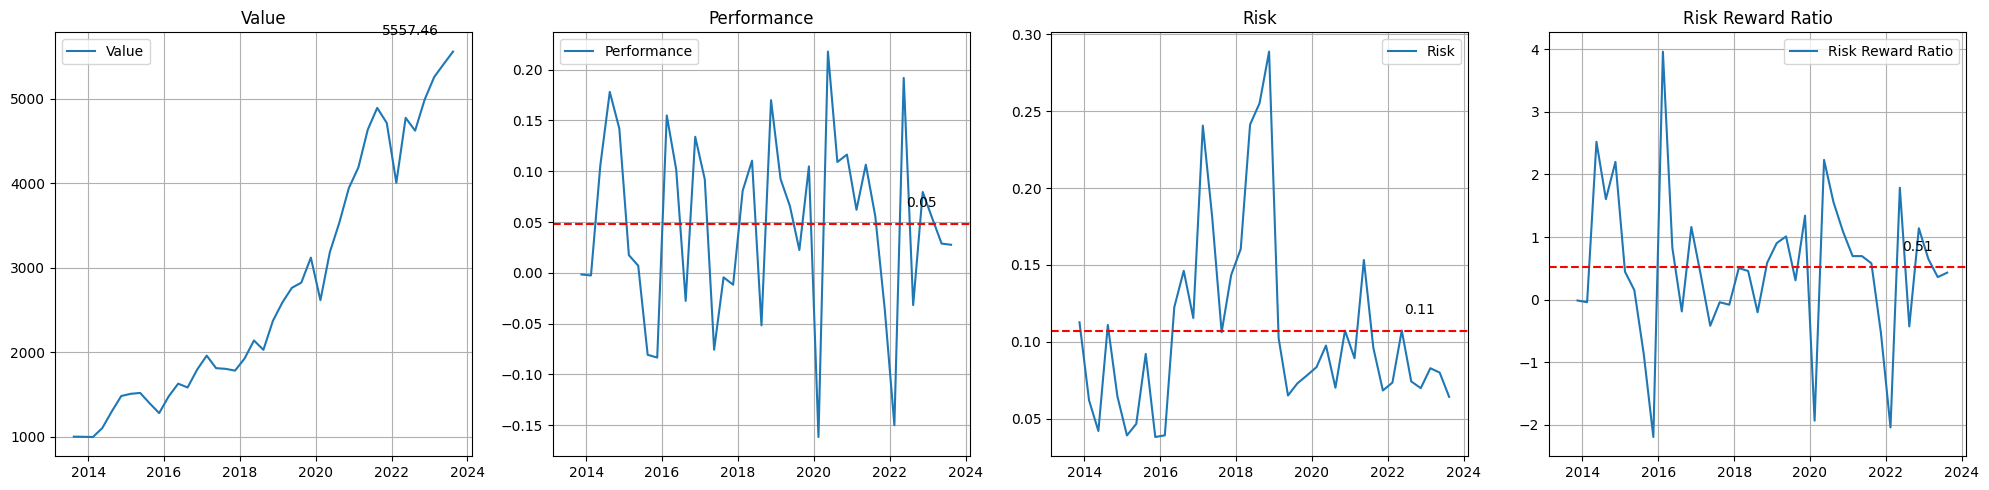

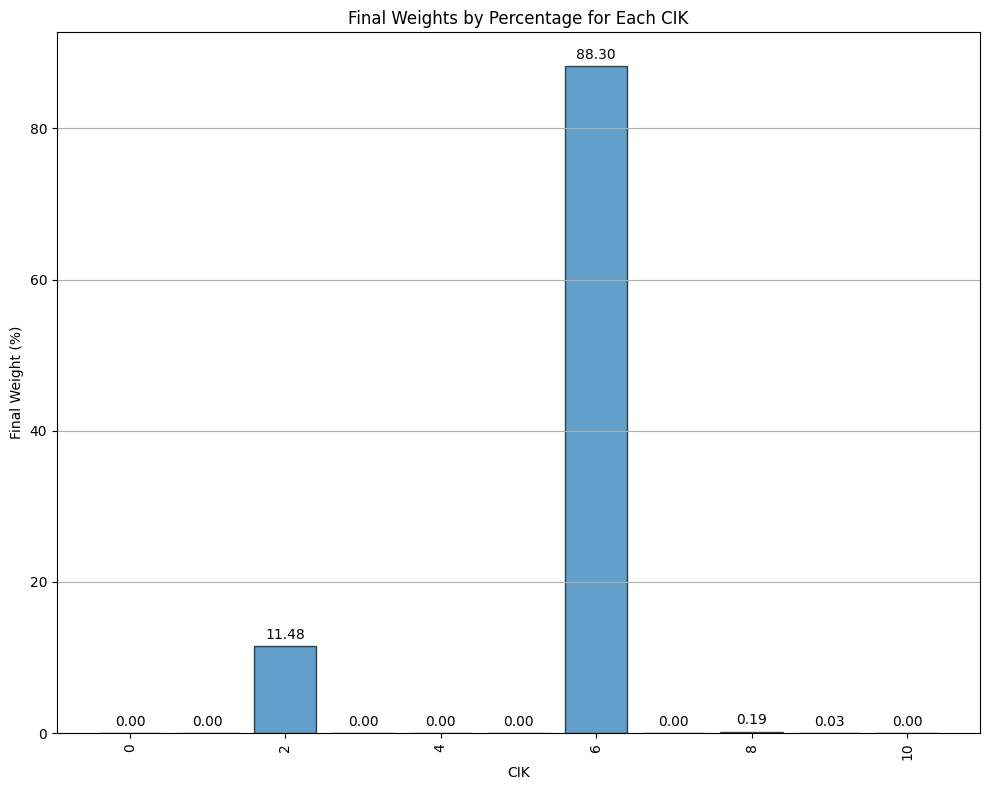

In [11]:
beta_values = np.linspace(0.01, 0.99, 99)
best_risk_reward, best_weights_risk_reward, beta_values_3, final_values_3 = wma.greedy_strategy(df_grouped, beta_values, criterion='risk_reward')
wma.plot_performance_metrics(best_risk_reward)
wma.plot_final_weights(best_weights_risk_reward)

# Weighted Majority Algorithm
- We can use the weighted majority algorithm to decide how much to invest in each fund manager on a quarterly basis based on their past performance.
- The algorithm is as follows:
    1. Initialize the weights of all the fund managers to 1.
    2. For each quarter, calculate the total return of each fund manager.
    3. Calculate the total return of the weighted majority algorithm by multiplying the weights of each fund manager by their total return and summing them up.
    4. Penalize the weights of the fund managers that performed poorly by multiplying them by some factor
    5. Repeat steps 2-4 for each quarter.
- We can tune the factor to get the best performance.

Optimal beta: 0.8200000000000001
Final value with optimal beta: 3594.1424222114797


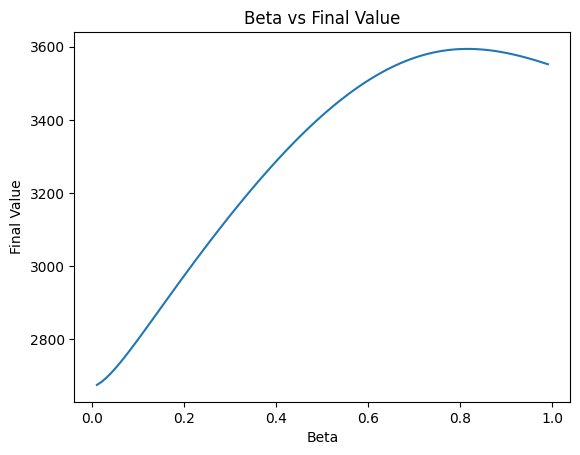

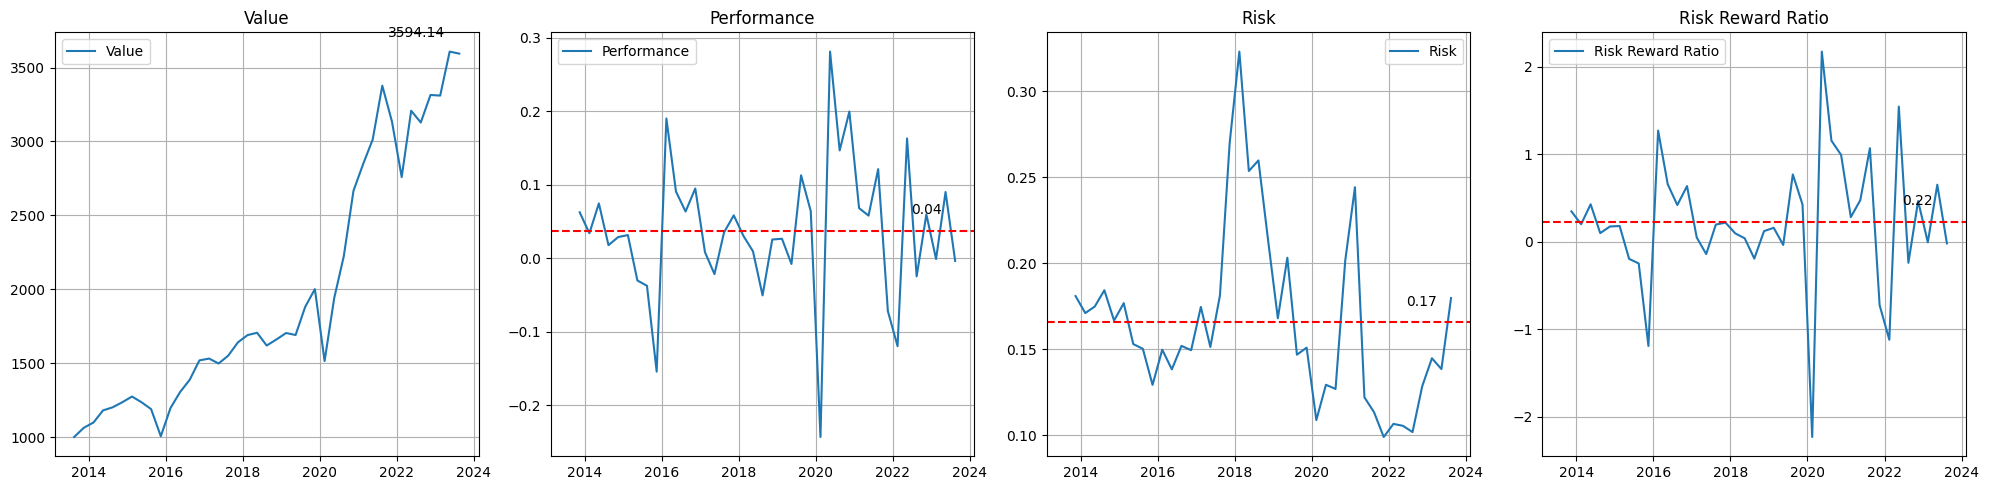

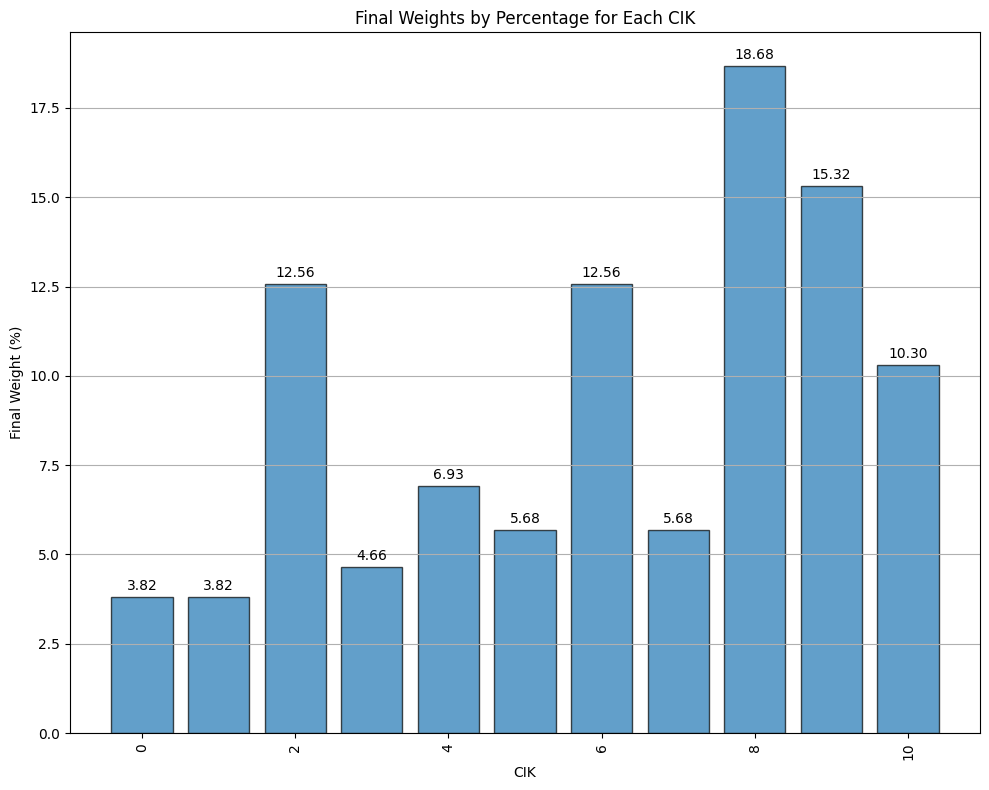

In [39]:
beta_values = np.linspace(0.01, 0.99, 99)
wma_performance, wma_weights, beta_values, final_values = wma.weighted_majority_algorithm(df_grouped, beta_values, criterion='performance')
wma.plot_performance_metrics(wma_performance)
wma.plot_final_weights(wma_weights)

In [40]:
# print final value, mean performance, risk and risk-reward for WMA strategy
final_value = wma_performance['Value'].iloc[-1]
mean_performance = wma_performance['Performance'].mean()
risk = wma_performance['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 3594.1424222114797
Mean Performance: 0.036849973188405084
Risk: 0.16560642253334817
Risk-Reward: 0.22251536277818335


Optimal beta: 0.01
Final value with optimal beta: -0.09269484077431958


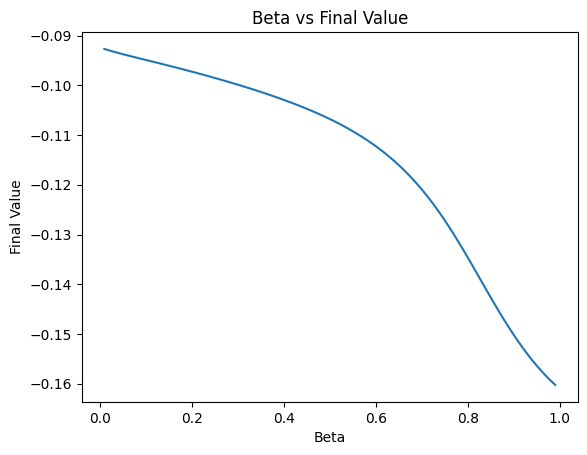

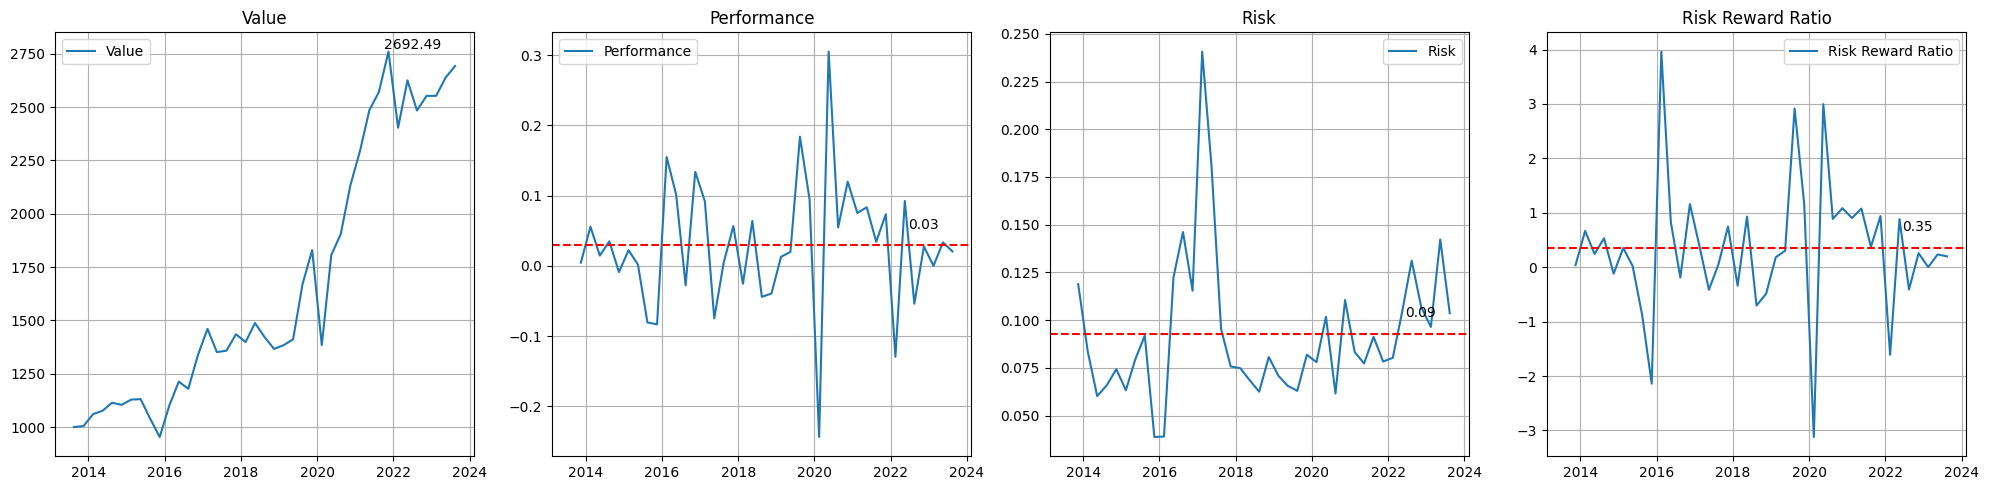

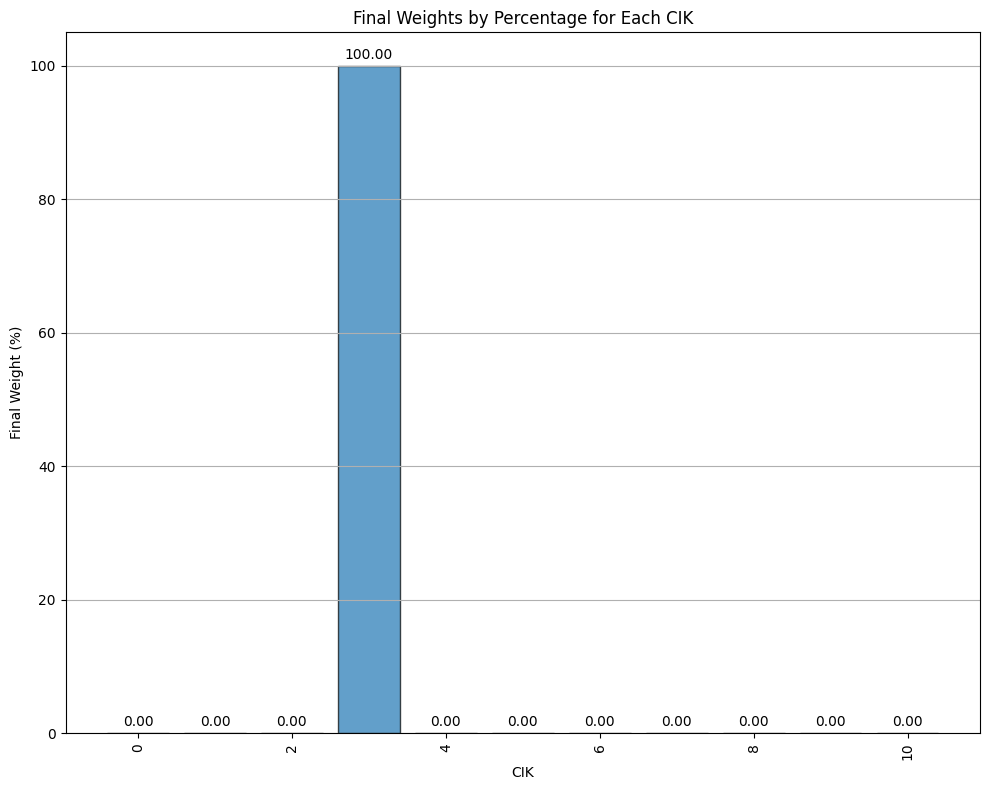

In [41]:
wma_performance, wma_weights, beta_values, final_values = wma.weighted_majority_algorithm(df_grouped, beta_values, criterion='risk')
wma.plot_performance_metrics(wma_performance)
wma.plot_final_weights(wma_weights)

In [42]:
# print final value, mean performance, risk and risk-reward for WMA strategy
final_value = wma_performance['Value'].iloc[-1]
mean_performance = wma_performance['Performance'].mean()
risk = wma_performance['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 2692.4888881805696
Mean Performance: 0.029101318691735066
Risk: 0.09269484077431958
Risk-Reward: 0.31394755575002153


Optimal beta: 0.01
Final value with optimal beta: 0.4901716958318679


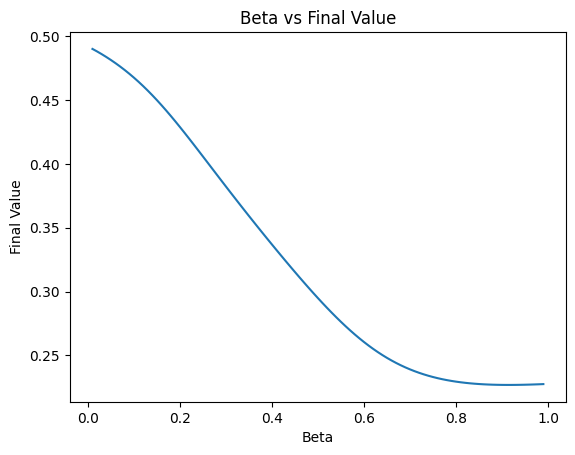

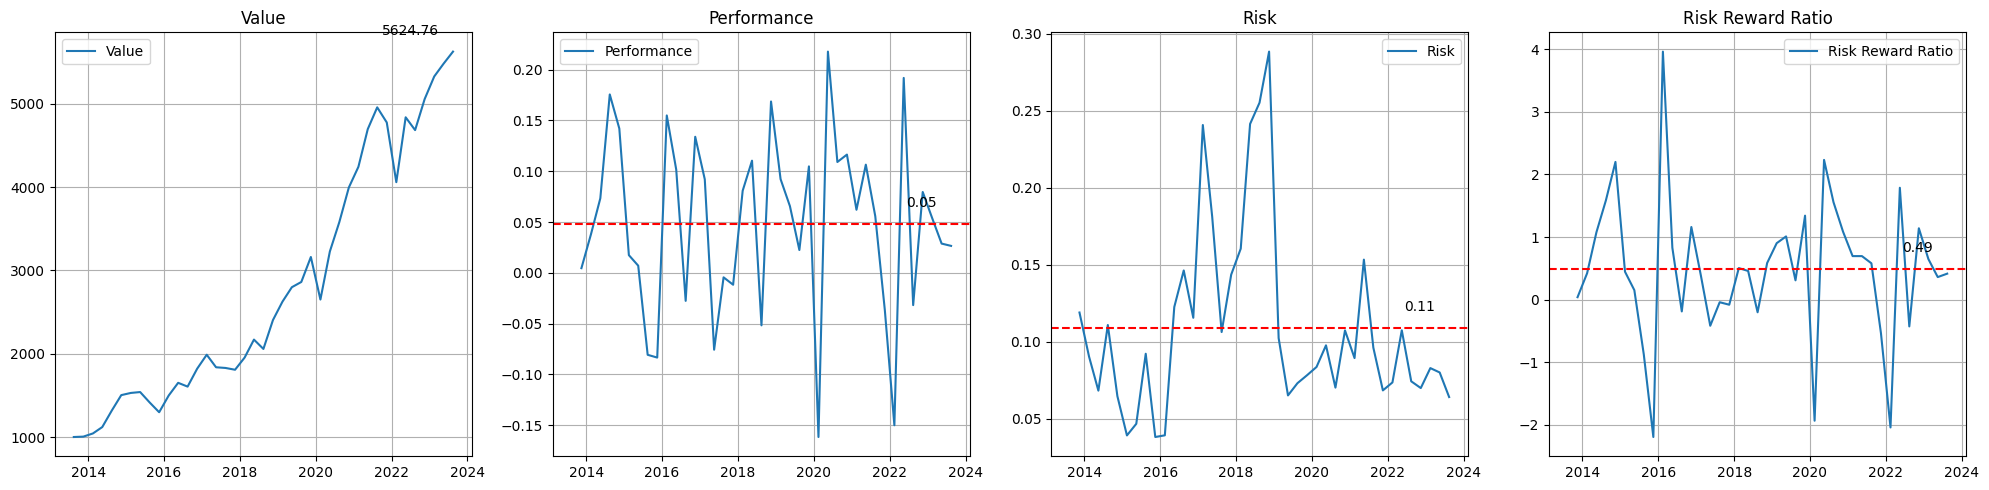

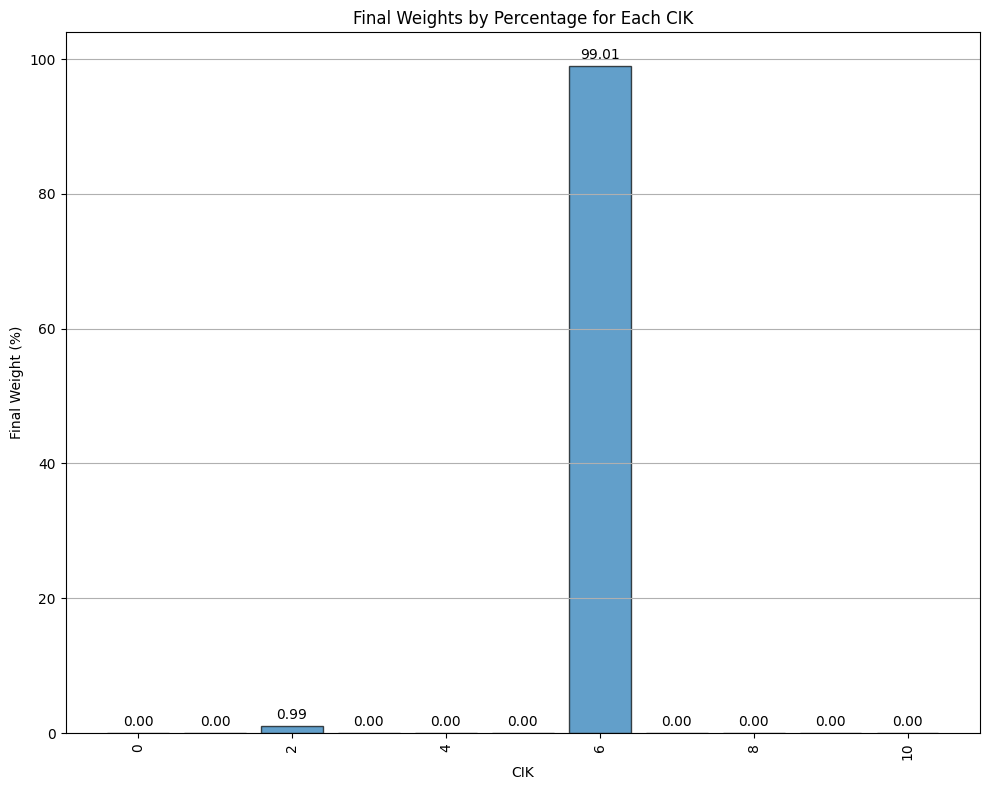

In [43]:
wma_performance, wma_weights, beta_values, final_values = wma.weighted_majority_algorithm(df_grouped, beta_values, criterion='risk_reward')
wma.plot_performance_metrics(wma_performance)
wma.plot_final_weights(wma_weights)

Optimal beta: 0.125
Final value with optimal beta: 0.4593583446568217


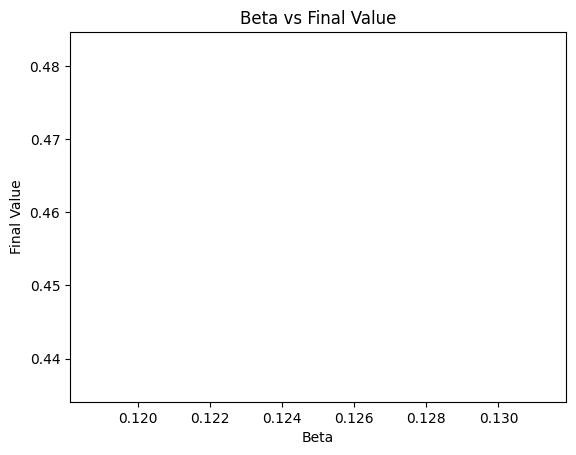

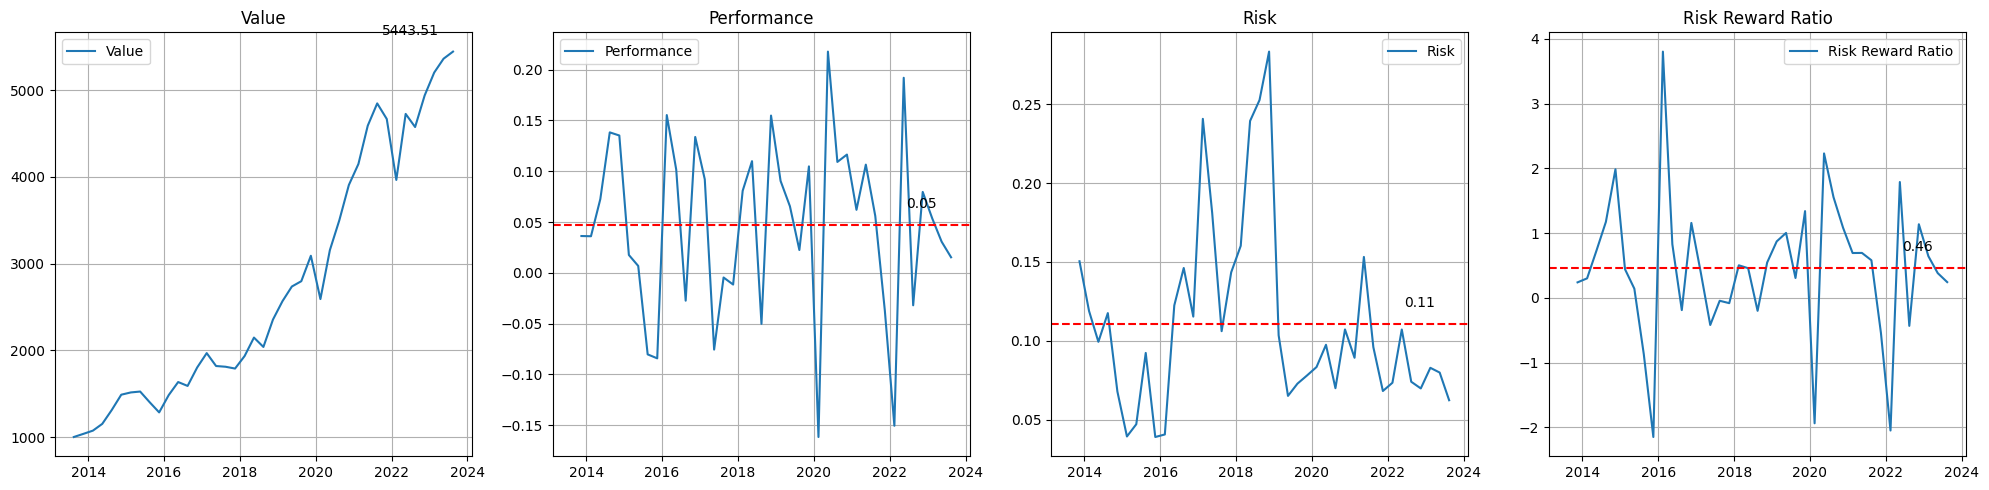

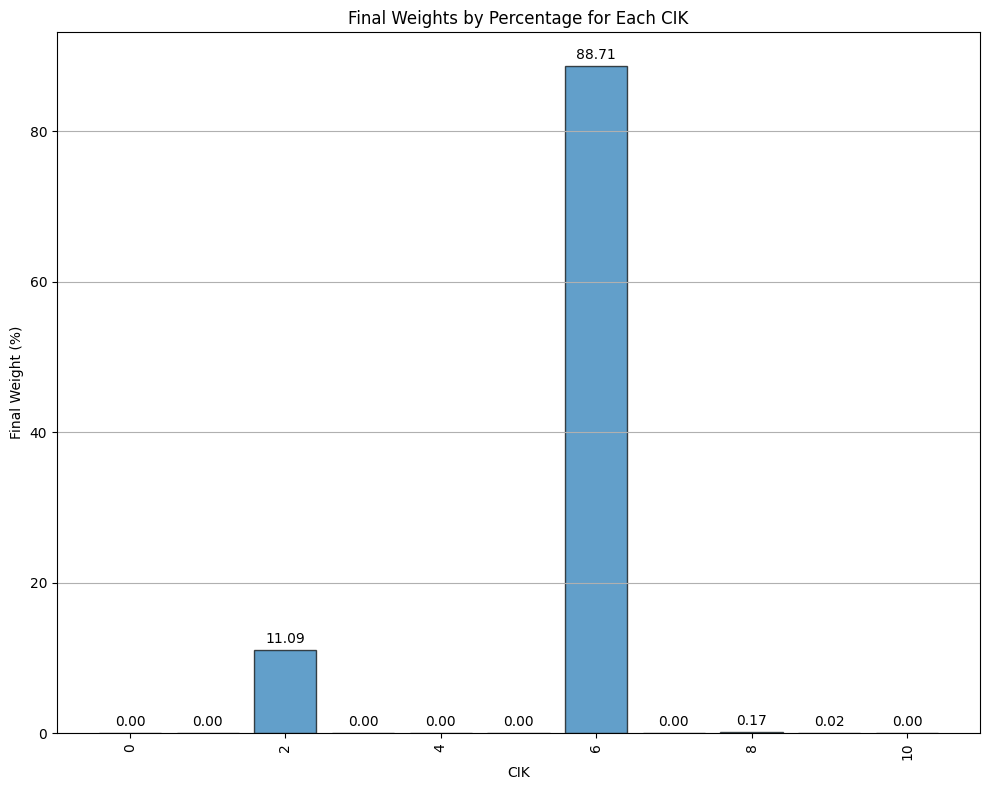

In [61]:
beta_values = [0.125]
wma_performance, wma_weights, beta_values, final_values = wma.weighted_majority_algorithm(df_grouped, beta_values, criterion='risk_reward')
wma.plot_performance_metrics(wma_performance)
wma.plot_final_weights(wma_weights)

In [44]:
# print final value, mean performance, risk and risk-reward for WMA strategy
final_value = wma_performance['Value'].iloc[-1]
mean_performance = wma_performance['Performance'].mean()
risk = wma_performance['Risk'].mean()
risk_reward = mean_performance / risk
print('Final Value:', final_value)
print('Mean Performance:', mean_performance)
print('Risk:', risk)
print('Risk-Reward:', risk_reward)

Final Value: 5624.762511703229
Mean Performance: 0.04794455504464858
Risk: 0.10857227137907625
Risk-Reward: 0.44159115799697934


## Randomized Weighted Majority Algorithm
- We can also use the randomized weighted majority algorithm to decide how much to invest in each fund manager on a quarterly basis based on their past performance.
- The algorithm is as follows:
    1. Initialize the weights of all the fund managers to 1.
    2. For each quarter, calculate the total return of each fund manager.
    3. Calculate the total return of the randomized weighted majority algorithm by multiplying the weights of each fund manager by their total return and summing them up.
    4. Penalize the weights of the fund managers that performed poorly by multiplying them by some factor
    5. Select a random fund manager to invest in based on the weights of the fund managers.
    6. Repeat steps 2-5 for each quarter.

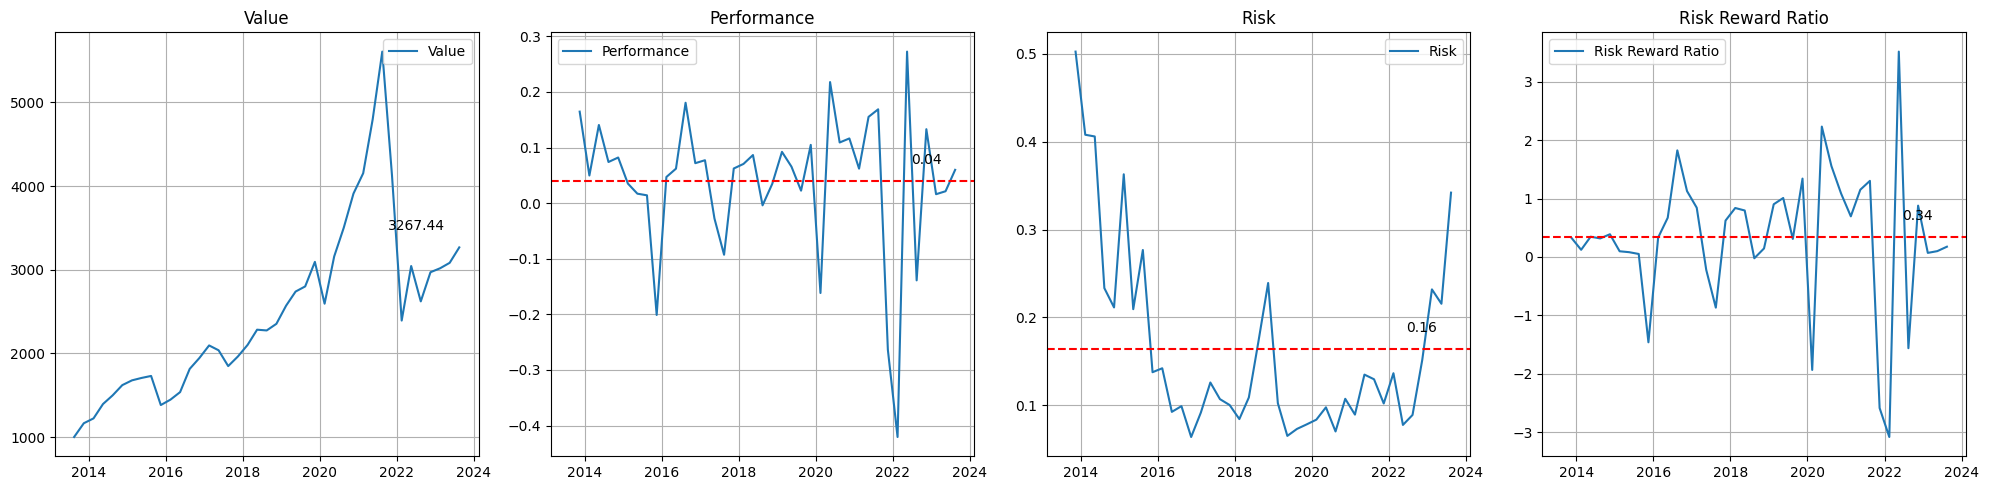

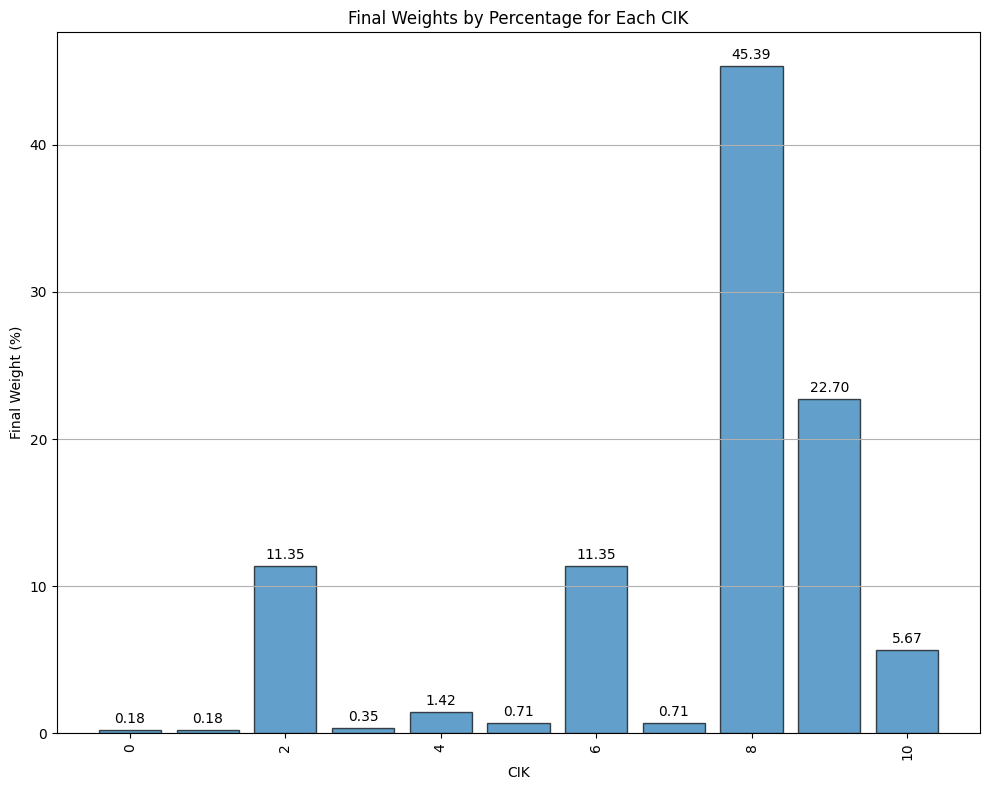

In [15]:
beta_values = [0.5]
rwm_performance, rwm_weights, beta_values_4, final_values_4 = wma.randomized_weighted_majority_algorithm(df_grouped, beta_values, criterion='performance', plot=False)
wma.plot_performance_metrics(best_performance)
wma.plot_final_weights(rwm_weights)

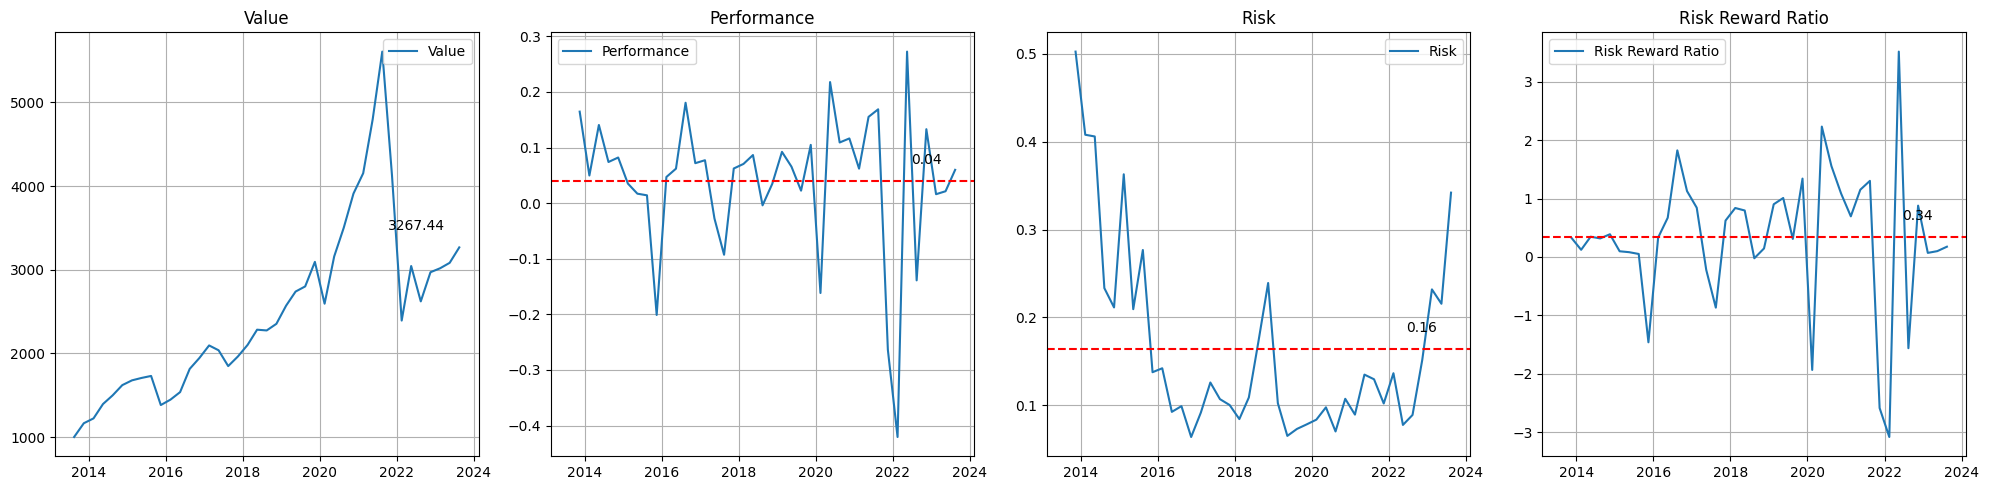

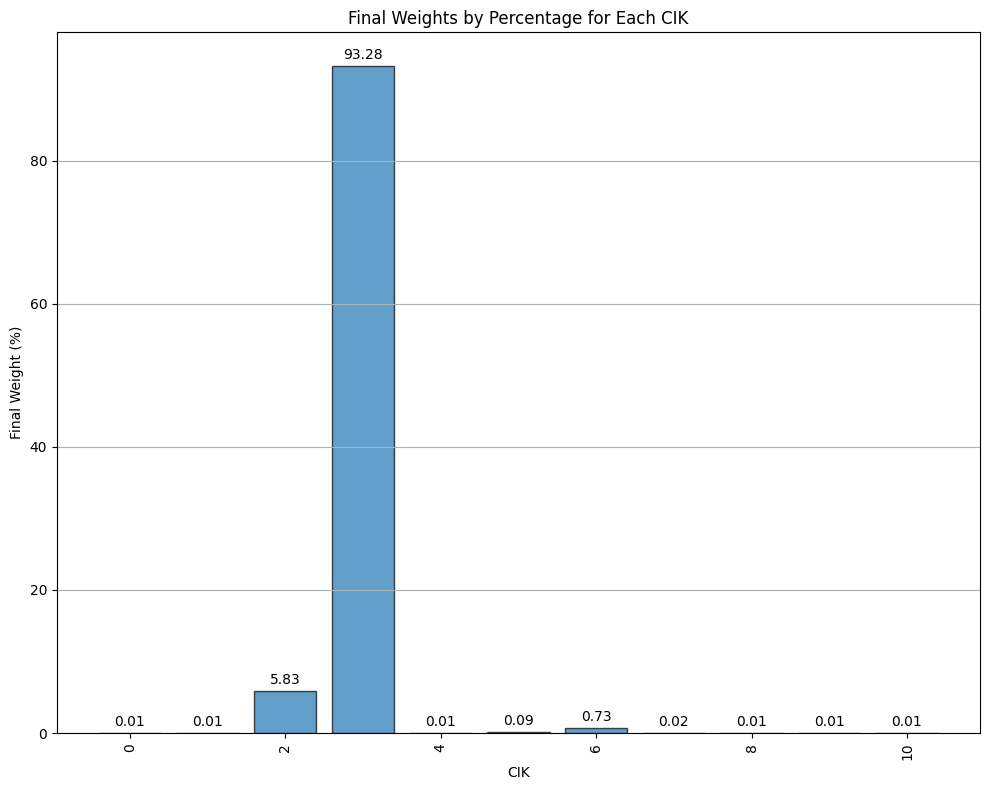

In [16]:
beta_values = [0.5]
rwm_risk, rwm_weights_risk, beta_values_5, final_values_5 = wma.randomized_weighted_majority_algorithm(df_grouped, beta_values, criterion='risk', plot=False)
wma.plot_performance_metrics(best_performance)
wma.plot_final_weights(rwm_weights_risk)

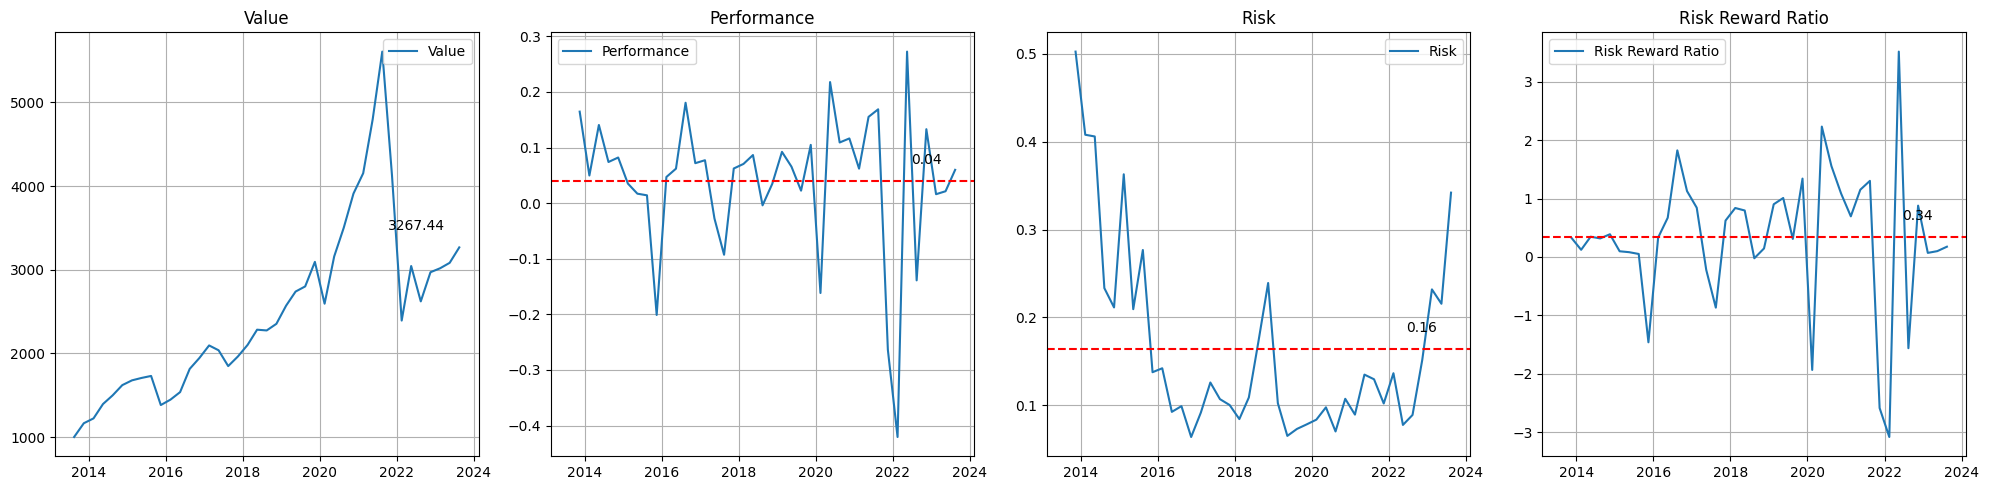

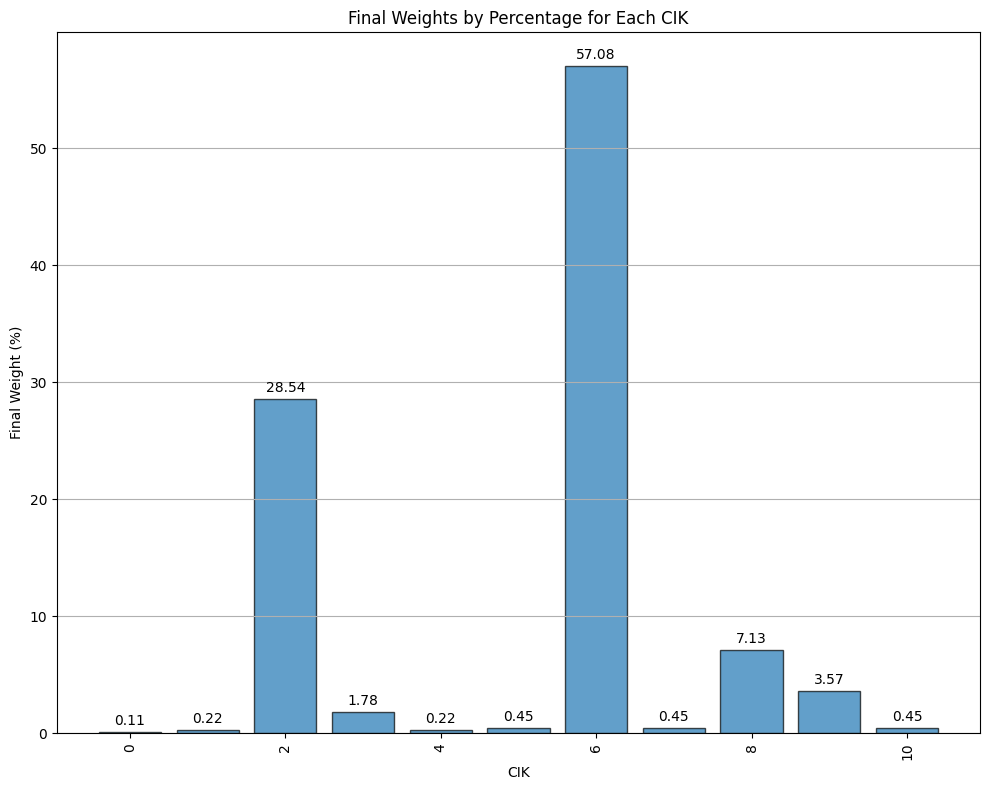

In [17]:
beta_values = [0.5]
rwm_risk_reward, rwm_weights_risk_reward, beta_values_6, final_values_6 = wma.randomized_weighted_majority_algorithm(df_grouped, beta_values, criterion='risk_reward', plot=False)
wma.plot_performance_metrics(best_performance)
wma.plot_final_weights(rwm_weights_risk_reward)

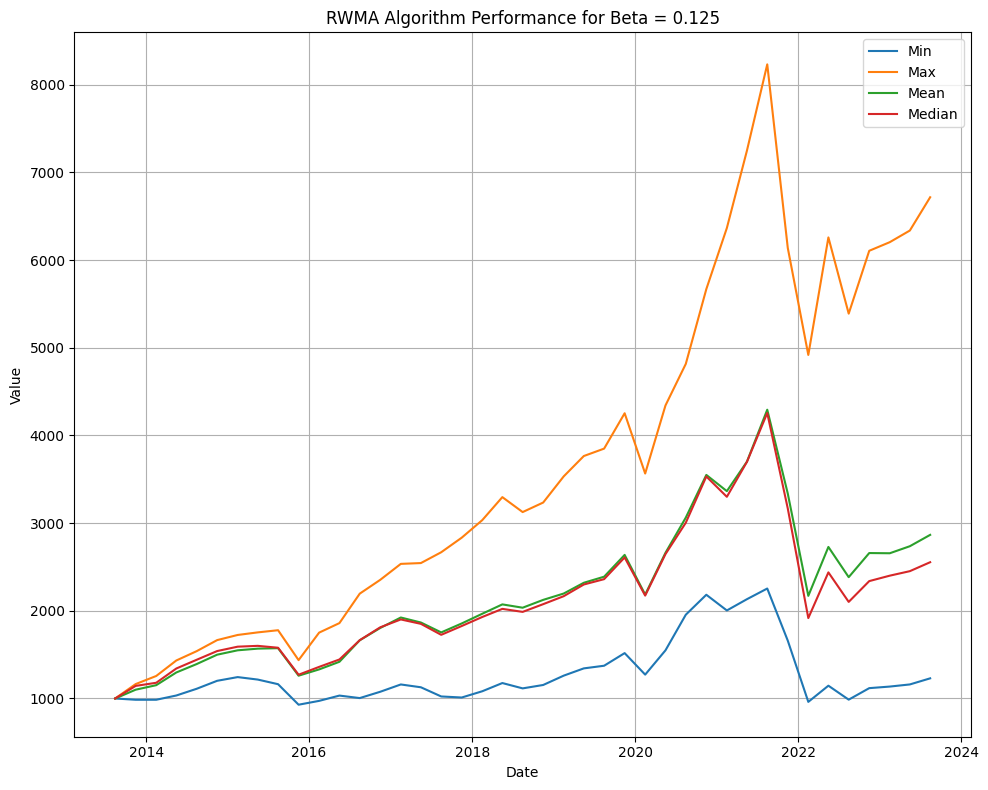

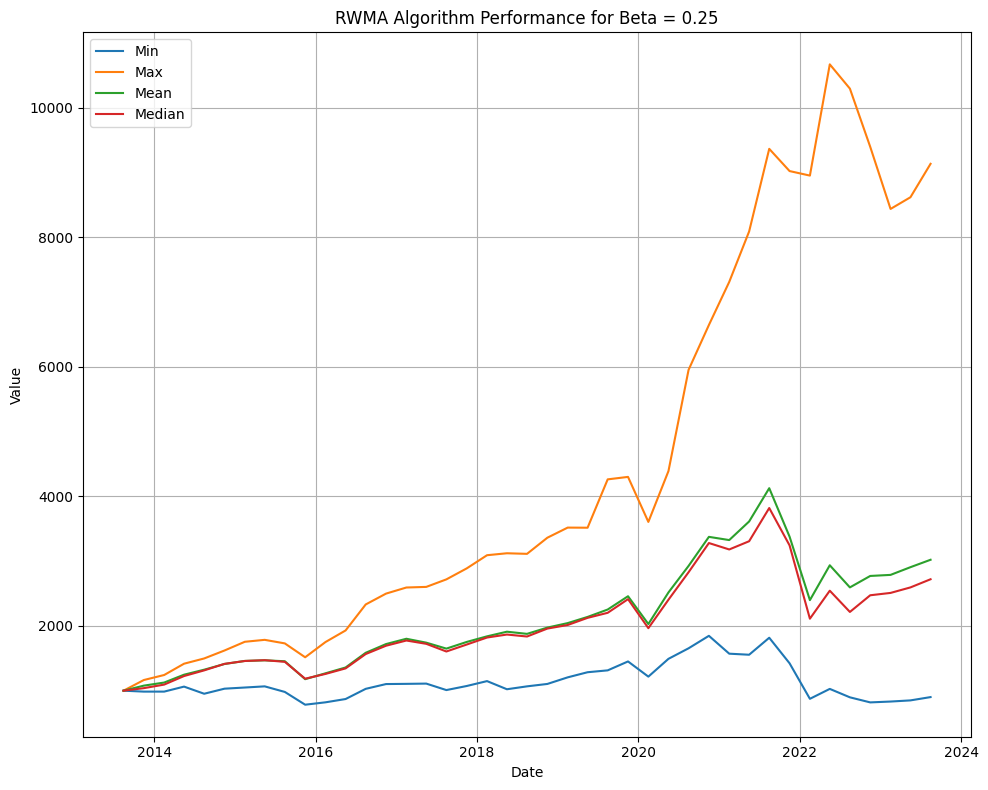

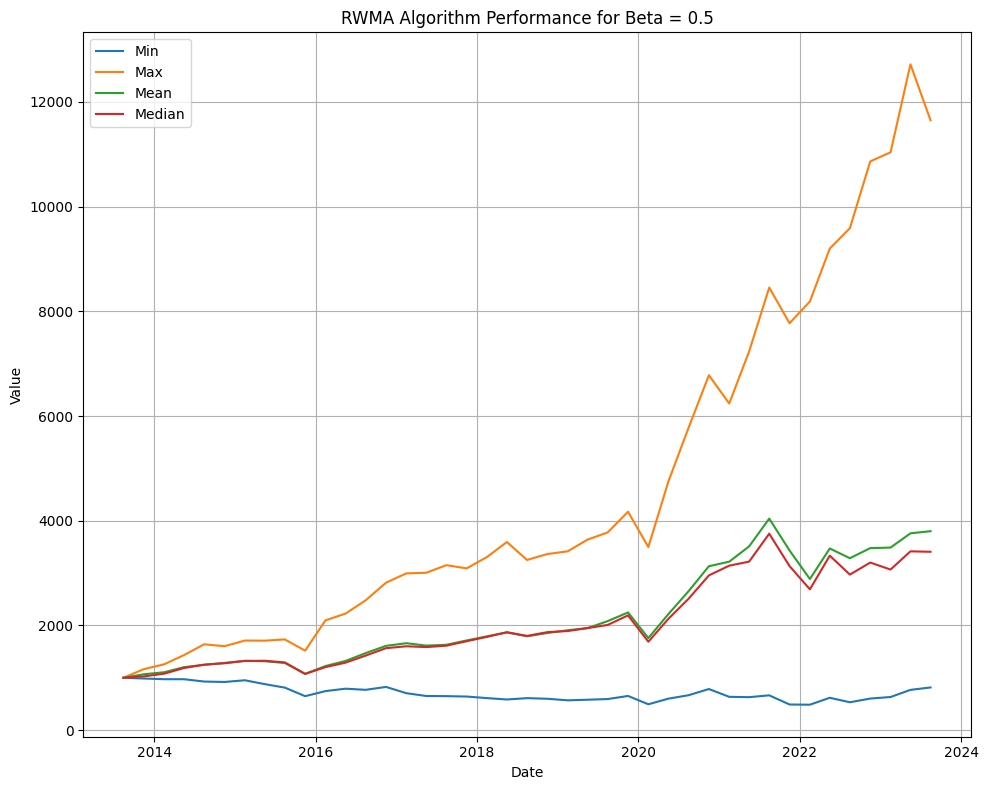

In [53]:
# using beta values 0.125, 0.25, 0.5, test the performance of the RWMA algorithm
# run the RWMA algorithm for performance criterion 100 times and plot the min, max, mean and median values for each time step

beta_values = [0.125, 0.25, 0.5]
n_iterations = 100

for beta in beta_values:
    values = []
    for i in range(n_iterations):
        rwm_performance, rwm_weights, beta_values, final_values = wma.randomized_weighted_majority_algorithm(df_grouped, [beta], criterion='performance', plot=False)
        values.append(rwm_performance['Value'])    
    values = np.array(values)
    plt.figure(figsize=(10, 8))
    plt.plot(rwm_performance.index, values.min(axis=0), label='Min')
    plt.plot(rwm_performance.index, values.max(axis=0), label='Max')
    plt.plot(rwm_performance.index, np.mean(values, axis=0), label='Mean')
    plt.plot(rwm_performance.index, np.median(values, axis=0), label='Median')
    # x-axis should be dates in the dataset
    plt.title('RWMA Algorithm Performance for Beta = ' + str(beta))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

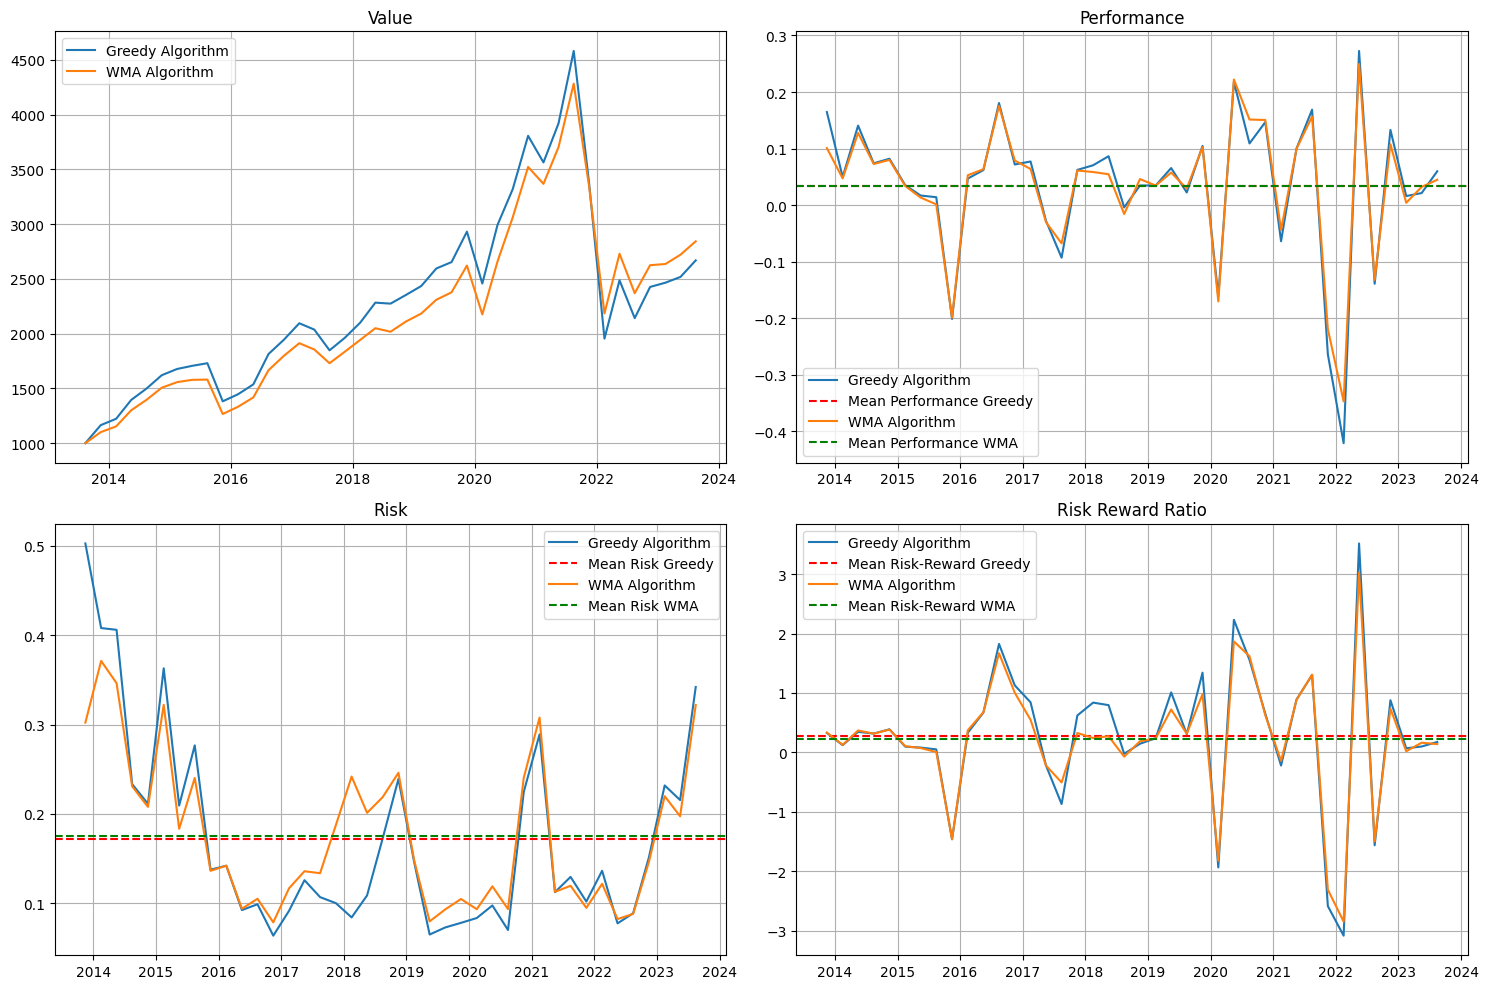

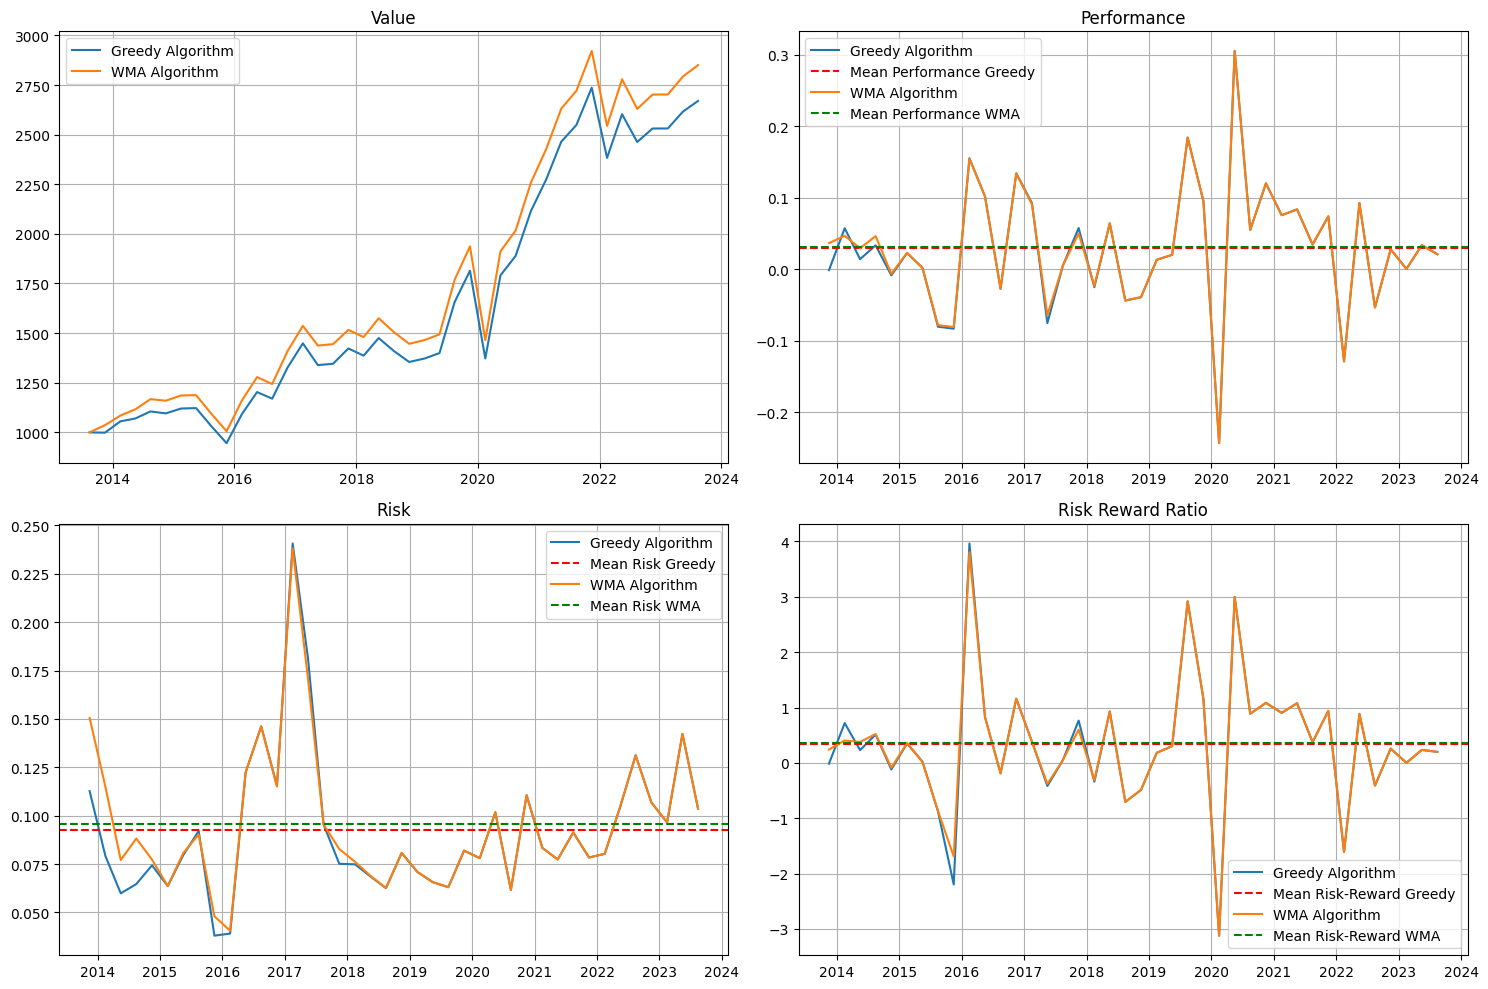

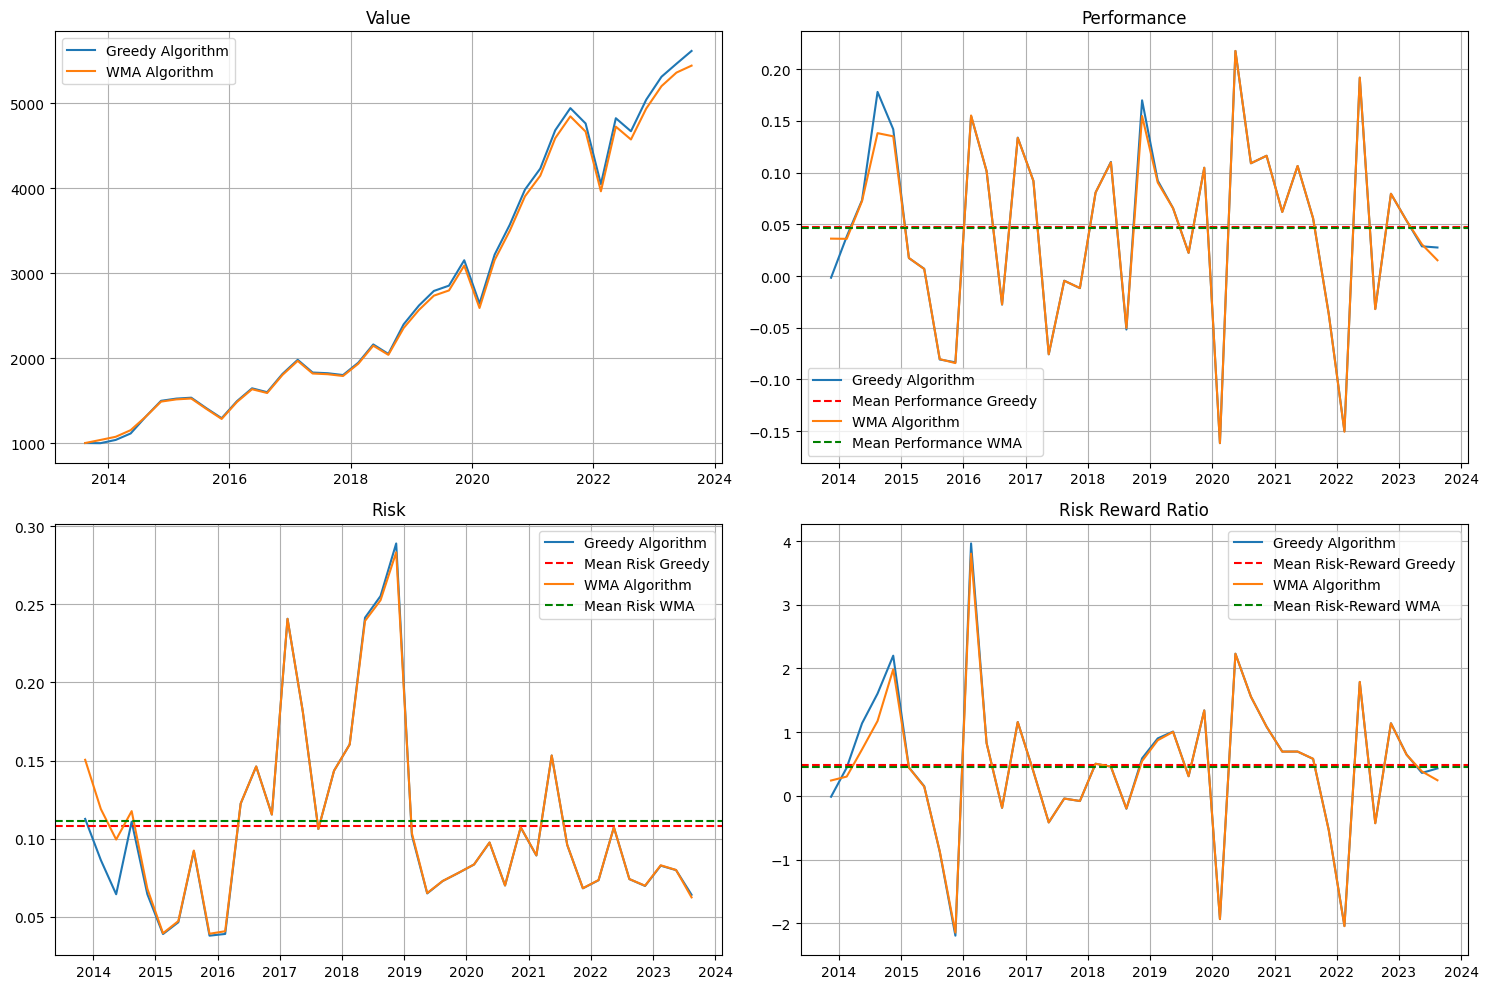

In [69]:
beta_values = [0.125]

# run modified greedy algorithm and WMA on all 3 criterion using beta values 0.125 and plot all the metrics on a same plot to compare.
for criteria in ['performance', 'risk', 'risk_reward']:
    best_performance, best_weights_performance, beta_values, final_values = wma.greedy_strategy(df_grouped, beta_values, criterion=criteria, plot=False)
    wma_performance, wma_weights, beta_values, final_values = wma.weighted_majority_algorithm(df_grouped, beta_values, criterion=criteria, plot=False)
    
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)
    ax[0, 0].plot(best_performance.index, best_performance['Value'], label='Greedy Algorithm')
    ax[0, 0].plot(wma_performance.index, wma_performance['Value'], label='WMA Algorithm')
    ax[0, 0].set_title('Value')
    ax[0, 0].legend()
    ax[0, 0].grid(True)

    ax[0, 1].plot(best_performance.index, best_performance['Performance'], label='Greedy Algorithm')
    ax[0, 1].axhline(y=best_performance['Performance'].mean(), color='r', linestyle='--', label='Mean Performance Greedy')
    ax[0, 1].plot(wma_performance.index, wma_performance['Performance'], label='WMA Algorithm')
    ax[0, 1].axhline(y=wma_performance['Performance'].mean(), color='g', linestyle='--', label='Mean Performance WMA')
    ax[0, 1].set_title('Performance')
    ax[0, 1].legend()
    ax[0, 1].grid(True)

    ax[1, 0].plot(best_performance.index, best_performance['Risk'], label='Greedy Algorithm')
    ax[1, 0].axhline(y=best_performance['Risk'].mean(), color='r', linestyle='--', label='Mean Risk Greedy')
    ax[1, 0].plot(wma_performance.index, wma_performance['Risk'], label='WMA Algorithm')
    ax[1, 0].axhline(y=wma_performance['Risk'].mean(), color='g', linestyle='--', label='Mean Risk WMA')
    ax[1, 0].set_title('Risk')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    ax[1, 1].plot(best_performance.index, best_performance['Risk Reward Ratio'], label='Greedy Algorithm')
    ax[1, 1].axhline(y=best_performance['Risk Reward Ratio'].mean(), color='r', linestyle='--', label='Mean Risk-Reward Greedy')
    ax[1, 1].plot(wma_performance.index, wma_performance['Risk Reward Ratio'], label='WMA Algorithm')
    ax[1, 1].axhline(y=wma_performance['Risk Reward Ratio'].mean(), color='g', linestyle='--', label='Mean Risk-Reward WMA')
    ax[1, 1].set_title('Risk Reward Ratio')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    plt.tight_layout()

    plt.show()
